In [48]:
# Simple WP, V field solver and signal generation
# Ren Cooper, LBNL & Joanna Szornel, UC Berkeley and LBNL
# Gamma-Ray Tracking School, ORNL, October 2018

In [49]:
%matplotlib inline
%reset -f

In [50]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

In [51]:
def import_drift_velocities(plot=False):
    # import drift velocities
    filename = './drift_velocities.txt'
    drift_velocity_table = np.genfromtxt(filename, comments='#', delimiter=None)
    
    E_vals = drift_velocity_table[:,0]
    e_vals = drift_velocity_table[:,1]
    h_vals = drift_velocity_table[:,4]
    x = np.linspace(0, 5000, 20)  # V/cm
    e_func = interp1d(E_vals, e_vals, kind='cubic')
    h_func = interp1d(E_vals, h_vals, kind='cubic')
    
    if plot == True:
        plt.plot(x,e_func(x),'--' )
        plt.plot(x,h_func(x),'--' )
        plt.plot()
        plt.ylabel('v (mm/ns)')
        plt.xlabel('E (V/cm)')
        plt.show()
    
    return x, e_func, h_func

x, efunc, hfunc = import_drift_velocities()

In [94]:
# set some detector parameters (mm)
strip_width_mm = 2.8
strip_gap_mm = 0.2
pixel_size_mm = 0.1

# set detector width to n*pitch where n is an odd number
#detector_width_mm = (3*strip_width_mm+strip_gap_mm)
detector_width_mm = strip_width_mm  * 3
#detector_width_mm = 10.0
detector_thickness_mm = 10.0 #16.0

outer_contact_bias = 1000.0
core_contact_bias = 0.0

charge_density_zero = -1.0
charge_density_gradient = 0.1

In [95]:
# build some grids
x_range = np.arange(-detector_width_mm/2 + pixel_size_mm, detector_width_mm/2 + pixel_size_mm, pixel_size_mm)
y_range = np.arange(-pixel_size_mm, detector_thickness_mm + pixel_size_mm, pixel_size_mm)

# initialize grid for solving for V
N_xelements = np.shape(x_range)[0]
N_yelements = np.shape(y_range)[0]
V = np.zeros((N_xelements, N_yelements), dtype=float)
W1 = np.zeros((N_xelements, N_yelements), dtype=float)
W2 = np.zeros((N_xelements, N_yelements), dtype=float)
E = np.zeros((N_xelements, N_yelements), dtype=float)

In [106]:
# build a little map of geometry for later, designating pixels based on their nature
# Ge = 0 strip = 1 rest of strip surface = 2, back contact = 3, gap = 4
geom_map = np.zeros((N_xelements, N_yelements), dtype=int)

# continous contact
#geom_map[:,0] = 3

#ix = np.where((x_range>=(-strip_width_mm/2 - strip_gap_mm - strip_width_mm)) \
# & (x_range<=(- strip_width_mm/2 - strip_gap_mm)))
#geom_map[ix,0] = 3

#ix = np.where((x_range>=(strip_width_mm/2 + strip_gap_mm)) \
#              & (x_range<=(strip_width_mm/2 + strip_gap_mm + strip_width_mm)))
#geom_map[ix,0] = 3

# BOTTOM
# strip surface
geom_map[:,0] = 6

ix = np.where((x_range>=(-strip_width_mm/2 - strip_gap_mm - strip_width_mm)) \
              & (x_range<=(- strip_width_mm/2 - strip_gap_mm)))
geom_map[ix,0] = 6

ix = np.where((x_range>=(strip_width_mm/2 + strip_gap_mm)) \
              & (x_range<=(strip_width_mm/2 + strip_gap_mm + strip_width_mm)))
geom_map[ix,0] = 6

# strip 
ix = np.where((x_range>=-strip_width_mm/2) & (x_range<=strip_width_mm/2))
geom_map[ix,0] = 5

# TOP
# strip surface
geom_map[:,-1] = 2

ix = np.where((x_range>=(-strip_width_mm/2 - strip_gap_mm - strip_width_mm)) \
              & (x_range<=(- strip_width_mm/2 - strip_gap_mm)))
geom_map[ix,-1] = 2

ix = np.where((x_range>=(strip_width_mm/2 + strip_gap_mm)) \
              & (x_range<=(strip_width_mm/2 + strip_gap_mm + strip_width_mm)))
geom_map[ix,-1] = 2

# strip 
ix = np.where((x_range>=-strip_width_mm/2) & (x_range<=strip_width_mm/2))
geom_map[ix,-1] = 1

# gap
ix = np.where((x_range>strip_width_mm/2) & (x_range<=(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,-1] = 4
ix = np.where((x_range<-strip_width_mm/2) & (x_range>=-(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,-1] = 4

ix = np.where((x_range>strip_width_mm/2) & (x_range<=(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,0] = 4
ix = np.where((x_range<-strip_width_mm/2) & (x_range>=-(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,0] = 4

# geom_map = np.zeros((N_xelements, N_yelements), dtype=int)
# geom_map[0,:] = 4
# geom_map[-1,:] = 4
# geom_map[:,0] = 3
# geom_map[:,-1] = 1

In [107]:
def V_geom_map(Nx, Ny):
    # Ge = 0 strip = 1 rest of strip surface = 2, back contact = 3, gap = 4
    geom_map = np.zeros((Nx, Ny), dtype=int)
    
    geom_map[0,:] = 4
    geom_map[-1,:] = 4
    geom_map[:,0] = 3
    geom_map[:,-1] = 1
    return geom_map

In [108]:
#geom_map = V_geom_map(N_xelements, N_yelements)
print(geom_map)

[[6 0 0 ..., 0 0 2]
 [6 0 0 ..., 0 0 2]
 [6 0 0 ..., 0 0 2]
 ..., 
 [6 0 0 ..., 0 0 2]
 [6 0 0 ..., 0 0 2]
 [6 0 0 ..., 0 0 2]]


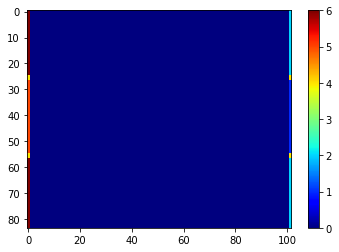

In [109]:
plt.imshow(geom_map, interpolation="None", cmap="jet")
plt.colorbar()
plt.show()

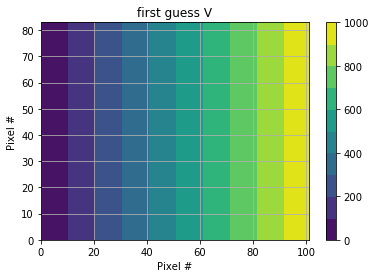

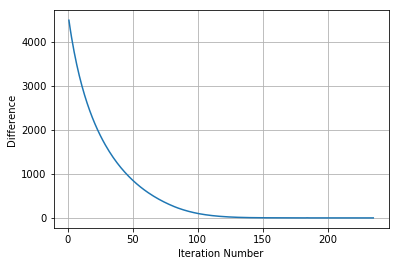

Final Difference:
0.00983916006109


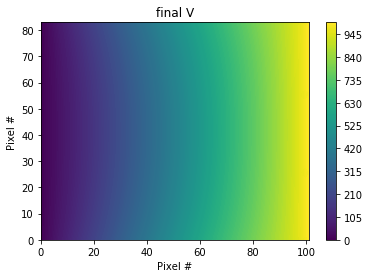

In [110]:
V = np.zeros((N_xelements, N_yelements), dtype=float)

#####

# set up charge distribution through xtal
charge = np.zeros((N_xelements, N_yelements), dtype=float)
pixels_to_cm = 10/pixel_size_mm

for x in range(0, N_xelements):
    for y in range(0, N_yelements):
        charge[x,y] = float(charge_density_zero + charge_density_gradient*(y/pixels_to_cm))

#print(geom_map)
#print(charge)

#####

# set boundary conditions and generate initial guess at solution

# initial guess at solution
for x in range(0, N_xelements):
    for y in range(0, N_yelements):
        V[x,y] = outer_contact_bias*y / N_yelements

# strip top
x,y = np.where(geom_map==1)
V[x,y] = outer_contact_bias

# other strips top
x,y = np.where(geom_map==2)
V[x,y] = outer_contact_bias

# strip top
x,y = np.where(geom_map==5)
V[x,y] = core_contact_bias

# other strips top
x,y = np.where(geom_map==6)
V[x,y] = core_contact_bias

# passivated back face (not tested)
#x,y = np.where(geom_map==3)
#V[x,y] = 0.0

#print(V)
plt.contourf(V,10,interpolation="None")
plt.grid("on")
plt.xlabel('Pixel #')
plt.ylabel('Pixel #')
plt.colorbar()
plt.title('first guess V')
plt.show()

# do the relaxation to solve

# set maximum number of iterations
max_iters = 1000

# calculate term for Coulombs per pixel / Epsilon
#e_over_e = (pixel_size_mm*pixel_size_mm) * 1e10 * 1.6e-19
e_over_e = (pixel_size_mm*pixel_size_mm/4)* (1e10*1.6e-19)/(16*8.85e-12)

# "over-relaxation" factor to speed up convergence
t = np.cos(3.14/N_xelements) + np.cos(3.14/N_yelements)
w = (8 - np.sqrt(64 - 16*t*t)) / (t*t)

# initialise arrays which will store the residuals
R = np.zeros((N_xelements, N_yelements), dtype=float)
resid_store = np.zeros(max_iters)

# perform relaxation...
resid = 1e6
iterr = 1
min_resid = 0.01
while (iterr < max_iters and resid > min_resid):    
    
    # loop over detector grid points
    for x in range(1, N_xelements - 1):
        for y in range(1, N_yelements - 1):
                        
            # skip non-Ge pixels
            if (geom_map[x,y] != 0):
                continue
                
            # deal with reflection symmetry at x=0
            #if (x == 0):
            #    V_local_sum = (V[x,y-1] + V[x,y+1] + 2.0*V[x+1,y])
            #
            #elif (y == 0):
            #    V_local_sum = (V[x-1,y] + V[x+1,y] + 2.0*V[x,y+1])

            # all other cases
            #else:                                
            #    V_local_sum = (V[x+1,y] + V[x,y+1] + V[x-1,y] + V[x,y-1])
            V_local_sum = (V[x+1,y] + V[x,y+1] + V[x-1,y] + V[x,y-1])
            
            # update the solution
            R[x,y] = (0.25*V_local_sum + (charge[x,y] * e_over_e)) - V[x,y]
            V[x,y] = V[x,y] + w*R[x,y]
                 
    # calculate the residual and store as a function of iteration number
    resid = abs(np.sum(R))
    resid_store[iterr] = resid
    
    # update iteration counter
    iterr+=1
# plot difference vs. iteration number
resid_store = resid_store[1:iterr]
plt.plot(np.arange(1,iterr), resid_store)
plt.grid("on")
plt.xlabel("Iteration Number")
plt.ylabel("Difference")
#plt.yscale("log")
plt.show()

# also print the final difference 
print("Final Difference:")
print(resid_store[-1])
plt.contourf(V, 200, vmin=0)
plt.xlabel('Pixel #')
plt.ylabel('Pixel #')
plt.colorbar()
plt.title('final V')
plt.show()

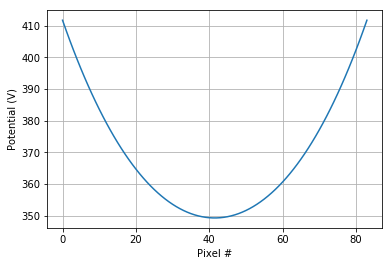

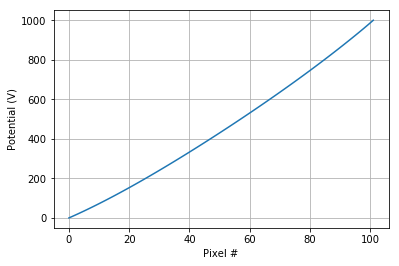

In [111]:
# plot some potential/field slices
yy = int(N_yelements / 2)
xx = int(N_xelements / 2)

# V along the radial direction at rad = xx
plt.plot(V[:,int(xx)])
plt.grid("on")
plt.xlabel("Pixel #")
plt.ylabel("Potential (V)")
plt.show()

# V along the longitudinal direction at long =yy
plt.plot(V[int(yy)])
plt.grid("on")
plt.xlabel("Pixel #")
plt.ylabel("Potential (V)")
plt.show()

Vslice = V[int(yy)]

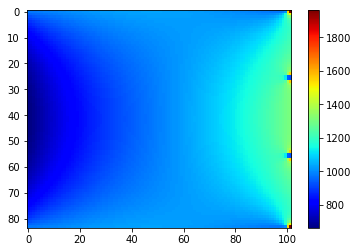

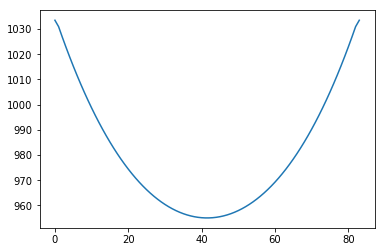

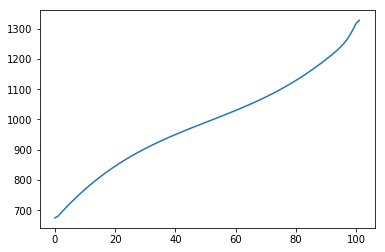

In [112]:
###### calculate the electric field from the potential
#  - this doesn't deal with boundaries properly!
[Ex, Ey] = np.gradient(-V)
Ex = Ex * pixels_to_cm
Ey = Ey * pixels_to_cm
E = np.sqrt((Ex*Ex) + (Ey*Ey))


#Efinal = np.flipud(E)
#Efinal = np.append(Efinal, E, axis=0)

Efinal = E

plt.imshow(Efinal[:,:], interpolation="None", cmap="jet")
plt.colorbar()
plt.show()
plt.plot( Efinal[:,int(xx)])
plt.show()
plt.plot( Efinal[yy])
plt.show()
#Eslice = Efinal[yy]
#plt.plot(Eslice,'o')
#plt.show()
Eslice = Efinal[yy]

# build a little map of geometry for later, designating pixels based on their nature
# Ge = 0 strip = 1 rest of strip surface = 2, back contact = 3, gap = 4
geom_map = np.zeros((N_xelements, N_yelements), dtype=int)

# continous contact
geom_map[:,0] = 3

ix = np.where((x_range>=(-strip_width_mm/2 - strip_gap_mm - strip_width_mm)) \
              & (x_range<=(- strip_width_mm/2 - strip_gap_mm)))
geom_map[ix,0] = 3

ix = np.where((x_range>=(strip_width_mm/2 + strip_gap_mm)) \
              & (x_range<=(strip_width_mm/2 + strip_gap_mm + strip_width_mm)))
geom_map[ix,0] = 3

# strip surface
geom_map[:,-1] = 2

ix = np.where((x_range>=(-strip_width_mm/2 - strip_gap_mm - strip_width_mm)) \
              & (x_range<=(- strip_width_mm/2 - strip_gap_mm)))
geom_map[ix,-1] = 2

ix = np.where((x_range>=(strip_width_mm/2 + strip_gap_mm)) \
              & (x_range<=(strip_width_mm/2 + strip_gap_mm + strip_width_mm)))
geom_map[ix,-1] = 2

# strip 
ix = np.where((x_range>=-strip_width_mm/2) & (x_range<=strip_width_mm/2))
geom_map[ix,-1] = 1

# gap
ix = np.where((x_range>strip_width_mm/2) & (x_range<=(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,-1] = 4
ix = np.where((x_range<-strip_width_mm/2) & (x_range>=-(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,-1] = 4

ix = np.where((x_range>strip_width_mm/2) & (x_range<=(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,0] = 4
ix = np.where((x_range<-strip_width_mm/2) & (x_range>=-(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,0] = 4

#geom_map = np.zeros((N_xelements, N_yelements), dtype=int)
#geom_map[0,:] = 4
#geom_map[-1,:] = 4
#geom_map[:,0] = 3
#geom_map[:,-1] = 1

In [115]:
# set boundary conditions 
# TOP
# non-strip contacts
[ix,iy] = np.where(geom_map == 2)
W1[ix,iy] = 0
#V[ix,iy] = 0

# back face
[ix,iy] = np.where(geom_map == 5)
W1[ix,iy] = 0
#V[ix,iy] = 1000

# back face
[ix,iy] = np.where(geom_map == 6)
W1[ix,iy] = 0
#V[ix,iy] = 1000

# strip
[ix,iy] = np.where(geom_map == 1)
W1[ix,iy] = 1
#V[ix,iy] = 0

# set boundary conditions 
# BOTTOM
# non-strip contacts
[ix,iy] = np.where(geom_map == 2)
W2[ix,iy] = 0
#V[ix,iy] = 0

# back face
[ix,iy] = np.where(geom_map == 5)
W2[ix,iy] = 1
#V[ix,iy] = 1000

# back face
[ix,iy] = np.where(geom_map == 6)
W2[ix,iy] = 0
#V[ix,iy] = 1000

# strip
[ix,iy] = np.where(geom_map == 1)
W2[ix,iy] = 0
#V[ix,iy] = 0

In [116]:
#geom_map = W_geom_map(N_xelements, N_yelements)
print(geom_map)

[[6 0 0 ..., 0 0 2]
 [6 0 0 ..., 0 0 2]
 [6 0 0 ..., 0 0 2]
 ..., 
 [6 0 0 ..., 0 0 2]
 [6 0 0 ..., 0 0 2]
 [6 0 0 ..., 0 0 2]]


In [117]:
# do the relaxation
# set maximum number of iterations
max_iters = 1000

# "over-relaxation" factor to speed up convergence
t = np.cos(3.14/N_xelements) + np.cos(3.14/N_yelements)
w = (8 - np.sqrt(64 - 16*t*t)) / (t*t)

# initialise arrays which will store the residuals
R = np.zeros((N_xelements, N_yelements), dtype=float)
resid_store = np.zeros(max_iters)

# perform relaxation...
resid = 1e6
iterr = 1
min_resid = 0.01

while (iterr < max_iters and resid > min_resid):    
    
    # loop over detector grid points
    for y in range(1, N_yelements-1):
        for x in range(0, N_xelements-1):
                        
            # skip pixels with boundary conditions
            if ((geom_map[x,y] == 1) or (geom_map[x,y] == 2) or (geom_map[x,y] == 3)):
                continue
                
            # should deal with some boundary conditions...
                                   
            W_local_sum = (W1[x+1,y] + W1[x,y+1] + W1[x-1,y] + W1[x,y-1])
            
            # update the solution
            R[x,y] = 0.25*W_local_sum - W1[x,y]
            W1[x,y] = W1[x,y] + w*R[x,y]
            
    # calculate the residual and store as a function of iteration number
    resid = abs(np.sum(R))
    resid_store[iterr] = resid
    
    # update iteration counter
    iterr+=1

In [ ]:
# visualise the weighting potential
# plot difference vs. iteration number
resid_store = resid_store[1:iterr]
plt.plot(np.arange(1,iterr), resid_store)
plt.grid("on")
plt.xlabel("Iteration Number")
plt.ylabel("Difference")
plt.yscale("log")
plt.show()

# also print the final difference 
print("Final Difference:")
print(resid_store[-1])

In [118]:
# do the relaxation
# set maximum number of iterations
max_iters = 1000

# "over-relaxation" factor to speed up convergence
t = np.cos(3.14/N_xelements) + np.cos(3.14/N_yelements)
w = (8 - np.sqrt(64 - 16*t*t)) / (t*t)

# initialise arrays which will store the residuals
R = np.zeros((N_xelements, N_yelements), dtype=float)
resid_store = np.zeros(max_iters)

# perform relaxation...
resid = 1e6
iterr = 1
min_resid = 0.01

while (iterr < max_iters and resid > min_resid):    
    
    # loop over detector grid points
    for y in range(1, N_yelements-1):
        for x in range(0, N_xelements-1):
                        
            # skip pixels with boundary conditions
            if ((geom_map[x,y] == 1) or (geom_map[x,y] == 2) or (geom_map[x,y] == 3)):
                continue
                
            # should deal with some boundary conditions...
                                   
            W_local_sum = (W2[x+1,y] + W2[x,y+1] + W2[x-1,y] + W2[x,y-1])
            
            # update the solution
            R[x,y] = 0.25*W_local_sum - W2[x,y]
            W2[x,y] = W2[x,y] + w*R[x,y]
            
    # calculate the residual and store as a function of iteration number
    resid = abs(np.sum(R))
    resid_store[iterr] = resid
    
    # update iteration counter
    iterr+=1

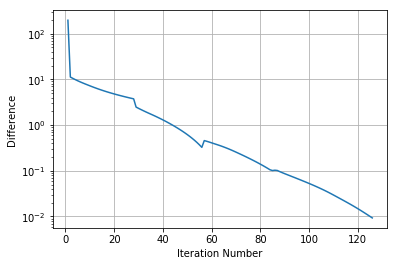

Final Difference:
0.00929549463753


In [119]:
# visualise the weighting potential
# plot difference vs. iteration number
resid_store = resid_store[1:iterr]
plt.plot(np.arange(1,iterr), resid_store)
plt.grid("on")
plt.xlabel("Iteration Number")
plt.ylabel("Difference")
plt.yscale("log")
plt.show()

# also print the final difference 
print("Final Difference:")
print(resid_store[-1])

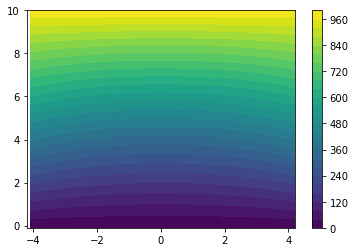

In [120]:
X, Y = np.meshgrid(y_range, x_range)
plt.contourf(Y,X, V, 30)
plt.xlim(-detector_width_mm/2, detector_width_mm/2)
plt.colorbar()

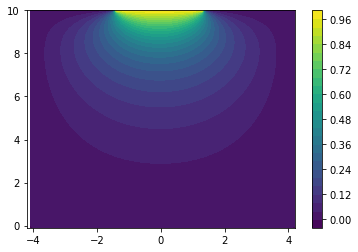

In [121]:
X, Y = np.meshgrid(y_range, x_range)
plt.contourf(Y,X, W1, 30)
plt.xlim(-detector_width_mm/2, detector_width_mm/2)
plt.colorbar()

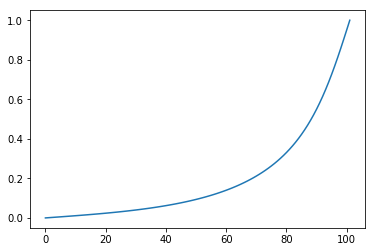

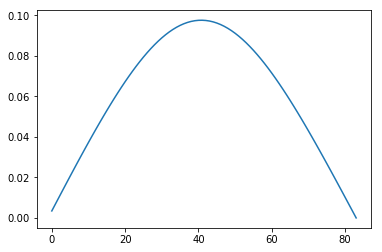

In [122]:
plt.plot(W1[int(xx),:])
plt.show()
plt.plot(W1[:,int(yy)])
plt.show()

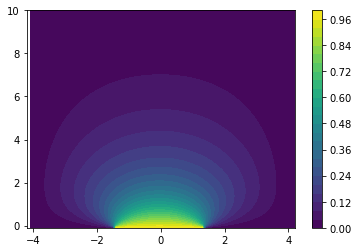

In [123]:
X, Y = np.meshgrid(y_range, x_range)
plt.contourf(Y,X, W2, 30)
plt.xlim(-detector_width_mm/2, detector_width_mm/2)
plt.colorbar()

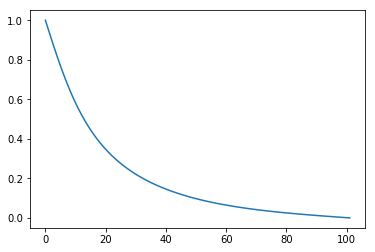

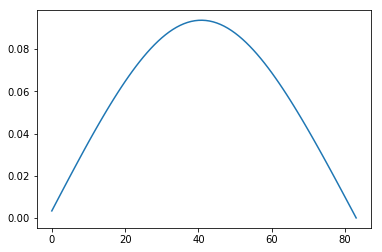

In [124]:
plt.plot(W2[int(xx),:])
plt.show()
plt.plot(W2[:,int(yy)])
plt.show()

In [125]:
y = np.linspace(0, N_yelements,N_yelements)

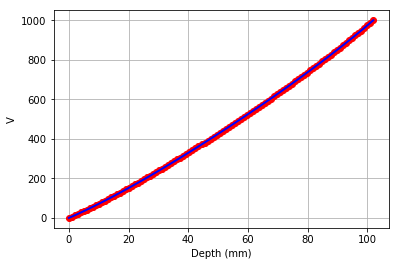

In [126]:
# take a slice through the V

Vslice = V[int(yy)]
Vfunc = interp1d(y, Vslice, kind='cubic')

plt.plot(y, Vfunc(y), 'ro',linewidth=1)
plt.plot(y, Vslice, 'b-',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("V")
#plt.xlim(0, 1.1)
#plt.ylim(0, 1000)

plt.show()

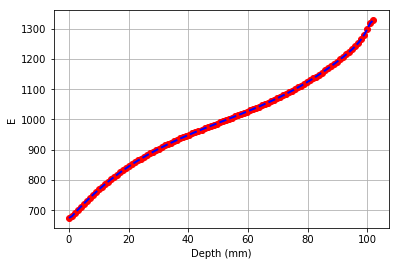

In [129]:
eps_0 = 8.85 * 10 ** (-14) 
eps = 16 * eps_0
rho = 10**10  # cm^-3
q = 1.6 * 10 ** (-19)
#Voltage = 1000 # V

#Eslice = Ez
#Eslice = np.insert(Eslice, 0, Eslice[0])
#y = np.linspace(0, N_yelements,N_yelements)

Efunc = interp1d(y, Eslice, kind='cubic')
plt.plot(y, Efunc(y), 'ro',linewidth=1)
plt.plot(y, Eslice, 'b--',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("E")
#plt.xlim(0, 16.1)
#plt.ylim(0, 1000)
plt.show()


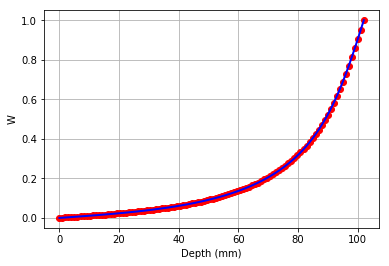

In [127]:

# take a slice through the W
x_slice = N_yelements/2
W1slice = W1[int(xx),:]
W1func = interp1d(y, W1slice, kind='cubic')

plt.plot(y, W1func(y), 'ro',linewidth=1)
plt.plot(y, W1slice, 'b-',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("W")
#plt.xlim(0, 1.1)
#plt.ylim(0, 1000)

plt.show()

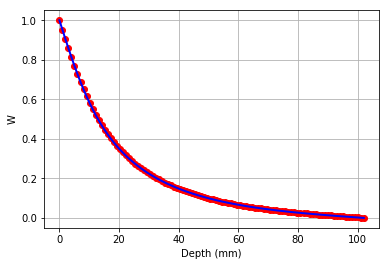

In [128]:

# take a slice through the W
x_slice = N_yelements/2
W2slice = W2[int(xx),:]
W2func = interp1d(y, W2slice, kind='cubic')

plt.plot(y, W2func(y), 'ro',linewidth=1)
plt.plot(y, W2slice, 'b-',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("W")
#plt.xlim(0, 1.1)
#plt.ylim(0, 1000)

plt.show()

z0:  90
0.4751
-0.5249


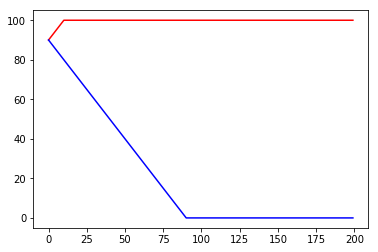

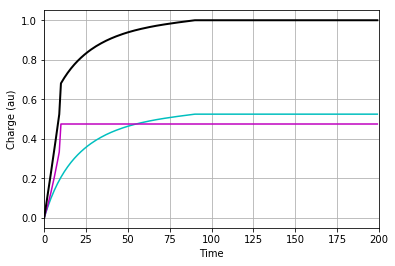

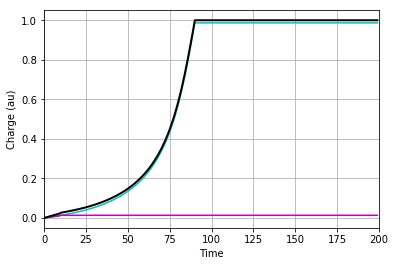

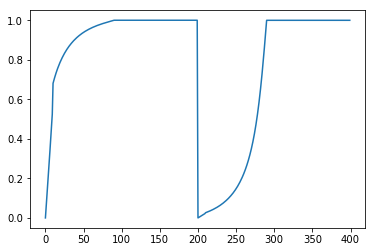

In [145]:
eps_0 = 8.85 * 10 ** (-14) 
eps = 16 * eps_0
rho = 10**10  # cm^-3
q = 1.6 * 10 ** (-19)
#Voltage = 1000 # V

# assume an interaction position at a given depth
depth_mm = detector_thickness_mm / 2
depth_mm = detector_thickness_mm - 1.0
maxval = detector_thickness_mm / pixel_size_mm

z0 = np.int(np.floor(depth_mm / pixel_size_mm))
print('z0: ',z0)

# number of time steps in signal
Nt = 200

# arrays which will store the induced charge signals
Qh1 = np.zeros(Nt, dtype=float) # 1 = top, 2 = bottom
Qe1 = np.zeros(Nt, dtype=float)
Qh2 = np.zeros(Nt, dtype=float)
Qe2 = np.zeros(Nt, dtype=float)

# starting positions for electrons and holes
zh_list = []
ze_list = []
zh_list.append(z0)
ze_list.append(z0)
# holes into wp
t = 0
w_e_vals = []
w_h_vals = []
zh = z0
ze = z0
zh_list
for t in range(1, Nt):
    #print(len(Eslice))
    #print(x)
    x = zh_list[-1]
    zh = zh_list[-1]
    eslice = Efunc(x)
    muh = float(hfunc(eslice))
    vh = muh * eslice
    zh = zh + 1
    #zh = np.int(zh + np.floor(vh / pixel_size_mm))

    #print(x, Eslice[x])
    #print(mue, muh)
    #print(vh)
    #print('zh', zh)

    if zh < 0:
        zh = 0
        #print('zero ', zh)
    elif zh > int(maxval):
        zh = int(maxval)
        #print('max ', zh)
    else:
        pass
    #print('zh1', zh)
    zh_list.append(zh)
    #print('=======')
    #print(zh_list)
    #print('zh2', zh)
    #x_list.append(x_list[-1] + np.floor(vh))
    if (zh== maxval) and (x!= maxval):
        dw = 1.0 - W1func(zh_list[t-1])
        w_h_vals.append(dw)
        Qh1[t] = round(1.0*dw,4)
        dw = 0 - W2func(zh_list[t-1])
        w_h_vals.append(dw)
        Qh2[t] = round(1.0*dw,4)
        #print(np.cumsum(Qh)[-1])
    elif (zh== maxval) and (x== maxval):
        dw = 0
        w_h_vals.append(0)
        Qh1[t] = round(1.0*dw,4)
        Qh2[t] = round(1.0*dw,4)
        #print(np.cumsum(Qh)[-1])
    elif (zh<=N_yelements-1):
        dw = W1func(zh_list[t]) - W1func(zh_list[t-1])
        #w_h_vals.append(dw)
        #w_h_vals.append(Wfunc(zh_list[t-1]))
        w_h_vals.append(dw)
        Qh1[t] = round(1.0*dw,4)
        dw = W2func(zh_list[t]) - W2func(zh_list[t-1])
        #w_h_vals.append(dw)
        #w_h_vals.append(Wfunc(zh_list[t-1]))
        w_h_vals.append(dw)
        Qh2[t] = round(1.0*dw,4)
        #print(np.cumsum(Qh)[-1])
for t in range(1, Nt):
    #print(x)
    x = ze_list[-1]
    ze = ze_list[-1]
   # print(x)
    #print('zh0', zh)
    eslice = Efunc(x)
    mue = float(efunc(eslice))
    ve = mue * eslice
    ze = ze - 1
   # print('ze ', ze)
    if ze < 0:
        ze = 0
    elif ze > int(maxval):
        ze = int(maxval)
    else:
        pass
   # print('ze1 ', ze)
    ze_list.append(ze)
    if (ze== 0) and (x!= 0):
        dw = 0- W1func(ze_list[t-1])
        #print('e1 ', Wfunc(ze_list[t]))
        #assert Wfunc(ze_list[t]) == 0
        #w_e_vals.append(dw)
        w_e_vals.append(dw)
        Qe1[t] = round(1.0*dw,4)
        
        dw = 1.0- W2func(ze_list[t-1])
        #print('e1 ', Wfunc(ze_list[t]))
        #assert Wfunc(ze_list[t]) == 0
        #w_e_vals.append(dw)
        w_e_vals.append(dw)
        Qe2[t] = round(1.0*dw,4)
        #print(np.cumsum(Qe)[-1])
    elif (ze== 0) and (x== 0):
        dw = 0
        #print('e2 ', Wfunc(ze_list[t]))
        #assert Wfunc(ze_list[t]) == 0
        w_e_vals.append(0)
        Qe1[t] = round(1.0*dw,4)
        dw = 0
        #print('e2 ', Wfunc(ze_list[t]))
        #assert Wfunc(ze_list[t]) == 0
        w_e_vals.append(0)
        Qe2[t] = round(1.0*dw,4)
        #print(np.cumsum(Qe)[-1])
    elif (ze<=N_yelements-1):
        dw = W1func(ze_list[t]) - W1func(ze_list[t-1])
        #w_e_vals.append(Wfunc(zh_list[t]))
        #w_e_vals.append(Wfunc(zh_list[t-1]))
        w_e_vals.append(dw)
        Qe1[t] = round(1.0*dw,4)
        dw = W2func(ze_list[t]) - W2func(ze_list[t-1])
        #w_e_vals.append(Wfunc(zh_list[t]))
        #w_e_vals.append(Wfunc(zh_list[t-1]))
        w_e_vals.append(dw)
        Qe2[t] = round(1.0*dw,4)
        #print(np.cumsum(Qe)[-1])
print(np.cumsum(Qh1)[-1])
print(np.cumsum(Qe1)[-1])
# electrons out of wp

Qh1 = Qh1
Qe1 = - Qe1

Qh2 = - Qh2
Qe2 =  Qe2
# take cumulative sums
Qsignal_h_1 = np.cumsum(Qh1)
Qsignal_e_1 = np.cumsum(Qe1)
Qsignal_1 = np.cumsum(Qe1 + Qh1)

Qsignal_h_2 = np.cumsum(Qh2)
Qsignal_e_2 = np.cumsum(Qe2)
Qsignal_2 = np.cumsum(Qe2 + Qh2)

plt.plot(zh_list,'r-')
plt.plot(ze_list,'b-')
plt.show()


#plt.plot(w_e_vals,'bo')
#plt.show()
#plt.plot(w_h_vals,'ro')
#plt.show()


# plot
plt.plot(Qsignal_e_1, 'c', linewidth=1.5)
plt.plot(Qsignal_h_1, 'm', linewidth=1.5)
plt.plot(Qsignal_1, 'k', linewidth=2)


plt.grid("on")
#plt.ylim(0,1)
plt.xlim(0, Nt)
#plt.tick_params(labelbottom="off")
plt.xlabel("Time")
plt.ylabel("Charge (au)")
#plt.legend()
plt.show()

# plot
plt.plot(Qsignal_e_2, 'c', linewidth=1.5)
plt.plot(Qsignal_h_2, 'm', linewidth=1.5)
plt.plot(Qsignal_2, 'k', linewidth=2)


plt.grid("on")
#plt.ylim(0,1)
plt.xlim(0, Nt)
#plt.tick_params(labelbottom="off")
plt.xlabel("Time")
plt.ylabel("Charge (au)")
#plt.legend()
plt.show()

plt.plot(np.concatenate((Qsignal_1,Qsignal_2)))
plt.show()

z0:  10
0.9858
-0.0144


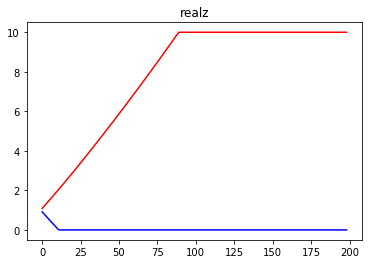

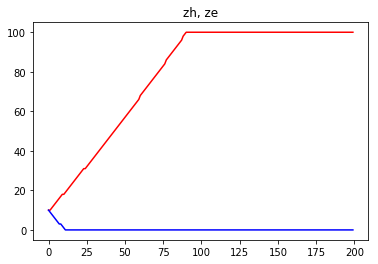

eh  1186.9114602
ee  622.474398384


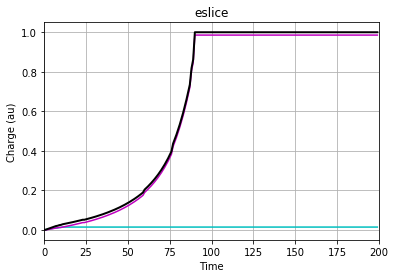

In [91]:
eps_0 = 8.85 * 10 ** (-14) # F /cm
eps = 16 * eps_0
rho = 10**10  # cm^-3
q = 1.6 * 10 ** (-19)
#Voltage = 1000 # V

# assume an interaction position at a given depth
depth_mm = detector_thickness_mm / 2
maxval = detector_thickness_mm / pixel_size_mm

z0 = np.int(np.floor(depth_mm / pixel_size_mm))
z0 = 10
print('z0: ',z0)

# number of time steps in signal
Nt = 200

# arrays which will store the induced charge signals
Qh = np.zeros(Nt, dtype=float)
Qe = np.zeros(Nt, dtype=float)

# starting positions for electrons and holes
zh_list = []
ze_list = []
zh_list.append(z0)
ze_list.append(z0)
# holes into wp
t = 0
w_e_vals = []
w_h_vals = []
zh = z0
ze = z0
realz_list_e = []
realz_list_h = []
realz = z0 * pixel_size_mm
e_slice_list_e = []
e_slice_list_h = []

for t in range(1, Nt):
    x = zh_list[-1]
    
    eslice = Efunc(float(realz / pixel_size_mm)) # realz in pixel
    vh = float(efunc(eslice))
    
    realz += round(float(vh),6)

    if realz <= 0:
        realz = 0
    elif realz >= maxval *pixel_size_mm:
        realz = maxval*pixel_size_mm    
    
    
    realz_list_h.append(realz)
    
    zh = int(realz / pixel_size_mm)
    e_slice_list_h.append(eslice)
    if zh < 0:
        zh = 0
    elif zh > int(maxval):
        zh = int(maxval)
    else:
        pass
    zh_list.append(zh)

    if (zh== maxval) and (x!= maxval):
        dw = 1.0 - Wfunc(zh_list[t-1])
        w_h_vals.append(dw)
        Qh[t] = round(1.0*dw,4)
    elif (zh== maxval) and (x== maxval):
        dw = 0
        w_h_vals.append(0)
        Qh[t] = round(1.0*dw,4)
    elif (zh<=N_yelements-1):
        dw = Wfunc(zh_list[t]) - Wfunc(zh_list[t-1])
        w_h_vals.append(dw)
        Qh[t] = round(1.0*dw,4)
        
realz = z0 * pixel_size_mm
for t in range(1, Nt):
    x = ze_list[-1]
    ze = ze_list[-1]

    eslice = Efunc(float(realz / pixel_size_mm)) # realz in pixel
    ve = float(efunc(eslice))

    realz += round(float(-1 * ve),6)
    
    if realz < 0:
        realz = 0
    elif realz > maxval:
        realz = maxval
    realz_list_e.append(realz)
    ze = int(realz/ pixel_size_mm)
    e_slice_list_e.append(eslice)
    
    if ze < 0:
        ze = 0
    elif ze > int(maxval):
        ze = int(maxval)
    else:
        pass
    ze_list.append(ze)
    if (ze== 0) and (x!= 0):
        dw = 0- Wfunc(ze_list[t-1])
        w_e_vals.append(dw)
        Qe[t] = round(1.0*dw,4)
    elif (ze== 0) and (x== 0):
        dw = 0
        w_e_vals.append(0)
        Qe[t] = round(1.0*dw,4)
    elif (ze<=N_yelements-1):
        dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
        w_e_vals.append(dw)
        Qe[t] = round(1.0*dw,4)
        
print(np.cumsum(Qh)[-1])
print(np.cumsum(Qe)[-1])
# electrons out of wp

Qh = Qh
Qe = - Qe
# take cumulative sums
Qsignal_h = np.cumsum(Qh)
Qsignal_e = np.cumsum(Qe)
Qsignal = np.cumsum(Qe + Qh)


plt.title('realz')
plt.plot(realz_list_h,'r-')
plt.plot(realz_list_e,'b-')
plt.show()


plt.title('zh, ze')
plt.plot(zh_list,'r-')
plt.plot(ze_list,'b-')
plt.show()


plt.title('eslice')
print('eh ', np.mean(e_slice_list_h))
print('ee ', np.mean(e_slice_list_e))
#plt.plot(w_e_vals,'bo')
#plt.show()
#plt.plot(w_h_vals,'ro')
#plt.show()


# plot
plt.plot(Qsignal_e, 'c', linewidth=1.5)
plt.plot(Qsignal_h, 'm', linewidth=1.5)
plt.plot(Qsignal, 'k', linewidth=2)

plt.grid("on")
#plt.ylim(0,1)
plt.xlim(0, Nt)
#plt.tick_params(labelbottom="off")
plt.xlabel("Time")
plt.ylabel("Charge (au)")
#plt.legend()
plt.show()

In [92]:
print(np.linspace(5, 100, 20))

[   5.   10.   15.   20.   25.   30.   35.   40.   45.   50.   55.   60.
   65.   70.   75.   80.   85.   90.   95.  100.]


z0:  0.0
1.0001
0.0


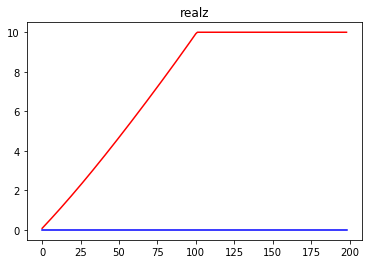

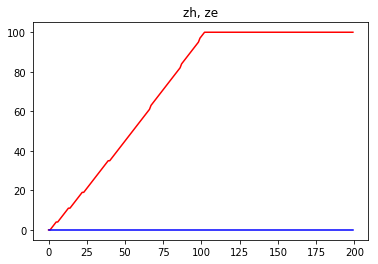

eh  1146.77467945
ee  619.458310949


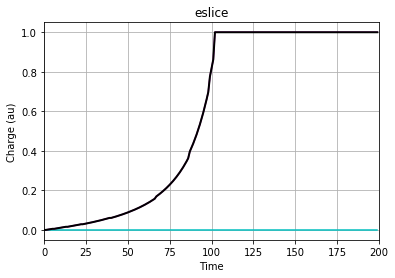

z0:  2.4358974359
0.9967
-0.0034


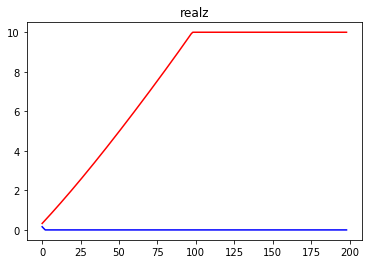

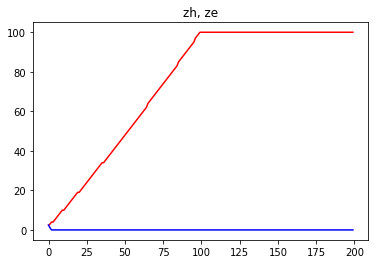

eh  1157.35027217
ee  619.641340582


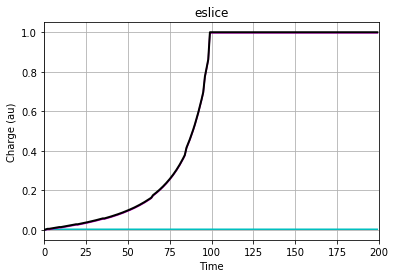

z0:  4.87179487179
0.9933
-0.0068


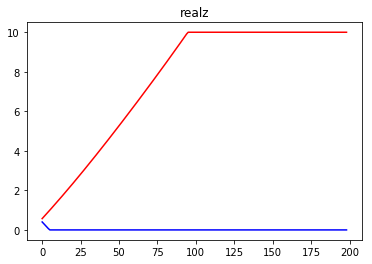

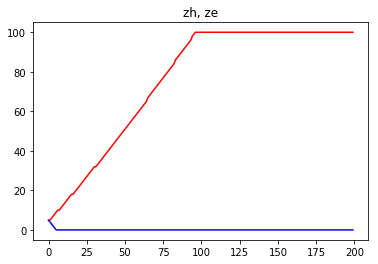

eh  1167.40059877
ee  620.197618448


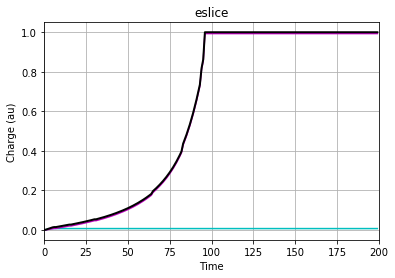

z0:  7.30769230769
0.9896
-0.0103


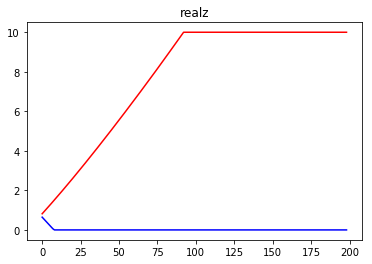

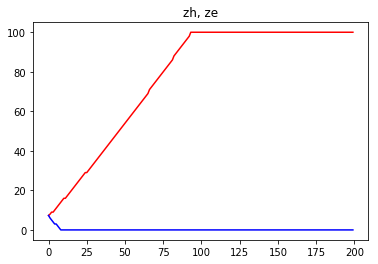

eh  1176.93353142
ee  621.101182132


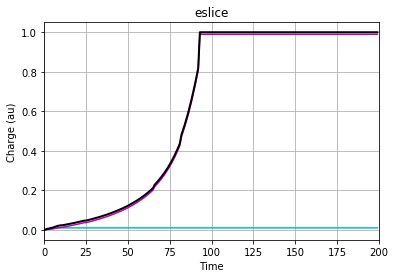

z0:  9.74358974359
0.9861
-0.014


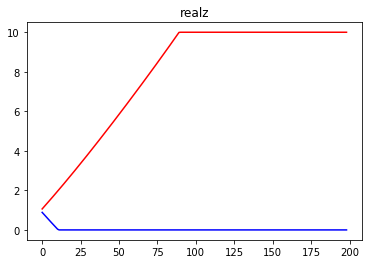

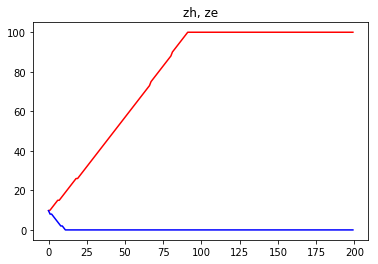

eh  1185.9873381
ee  622.327249443


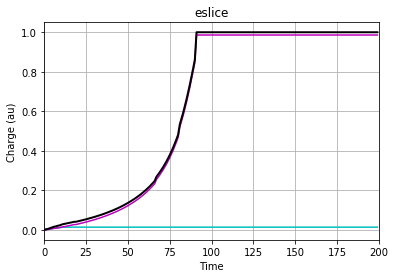

z0:  12.1794871795
0.9825
-0.0177


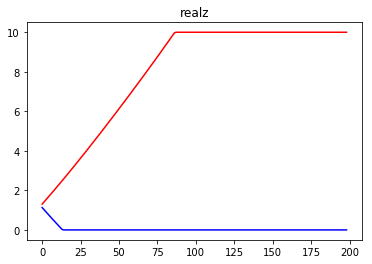

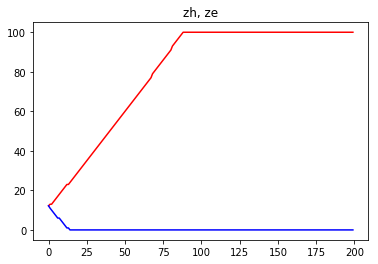

eh  1194.59648648
ee  623.853367788


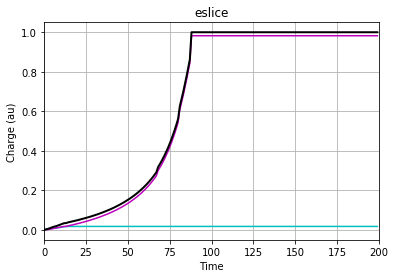

z0:  14.6153846154
0.9786
-0.0214


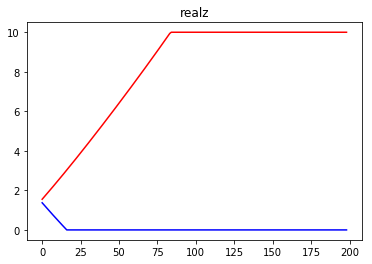

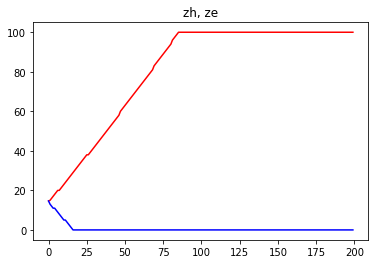

eh  1202.79902328
ee  625.659376573


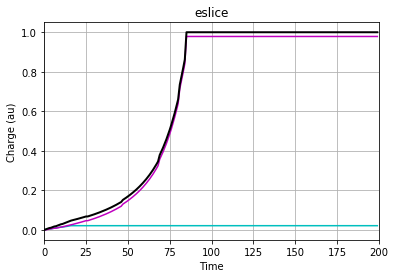

z0:  17.0512820513
0.9747
-0.0254


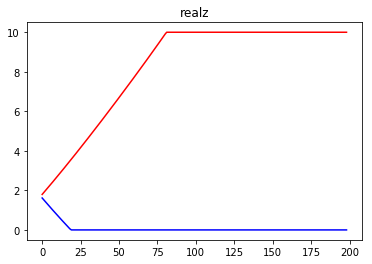

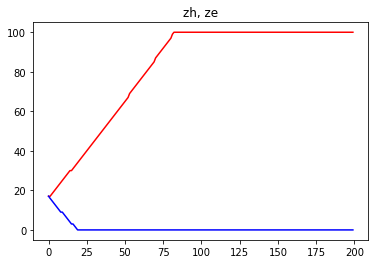

eh  1210.62402416
ee  627.725686199


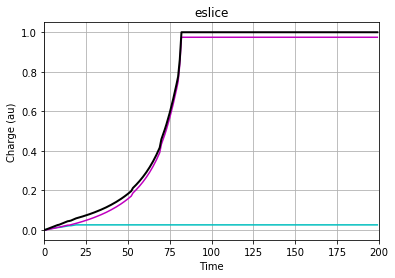

z0:  19.4871794872
0.9708
-0.0294


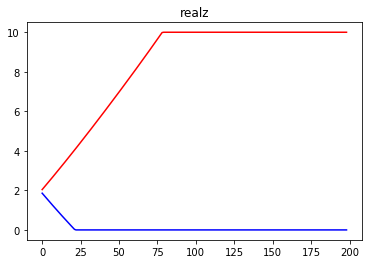

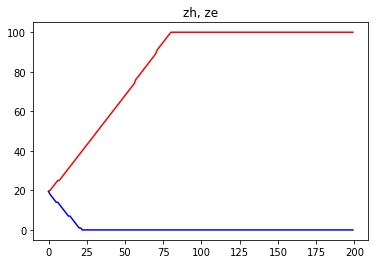

eh  1218.08887693
ee  630.033433019


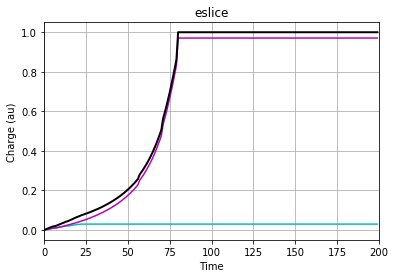

z0:  21.9230769231
0.9664
-0.0337


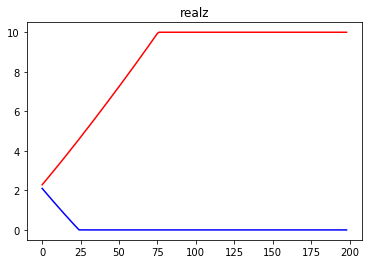

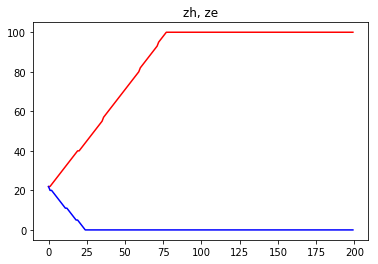

eh  1225.21609958
ee  632.567896644


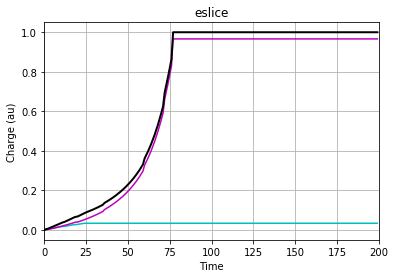

z0:  24.358974359
0.9619
-0.0381


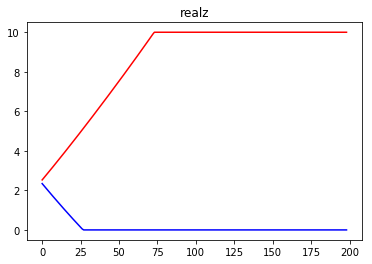

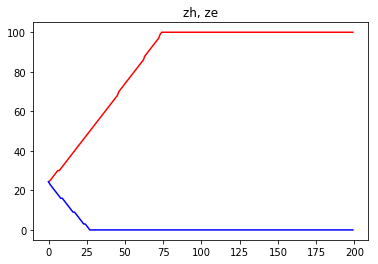

eh  1232.03842162
ee  635.314932808


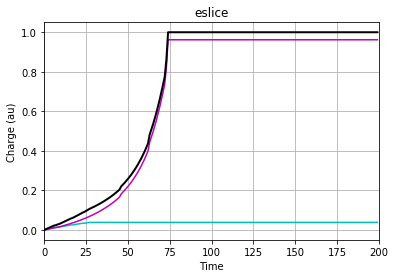

z0:  26.7948717949
0.9573
-0.0428


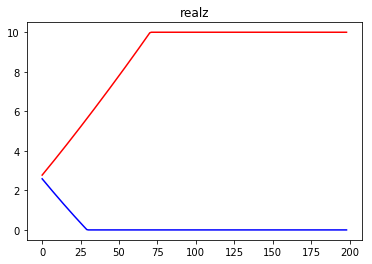

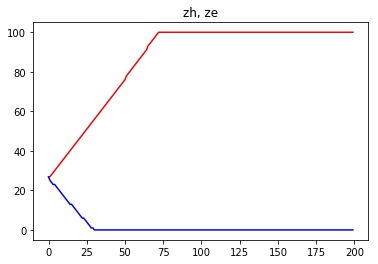

eh  1238.56186906
ee  638.259892875


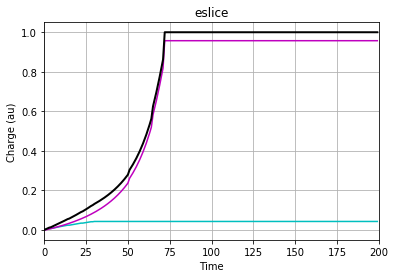

z0:  29.2307692308
0.9524
-0.0477


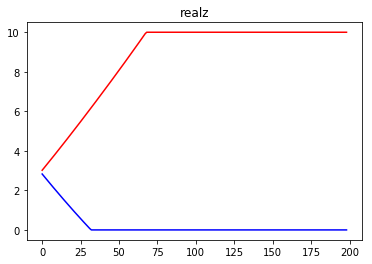

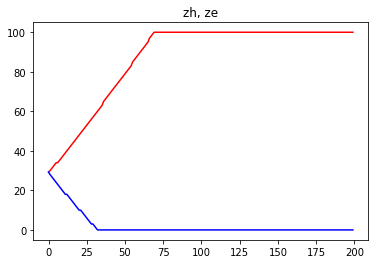

eh  1244.81167075
ee  641.393682728


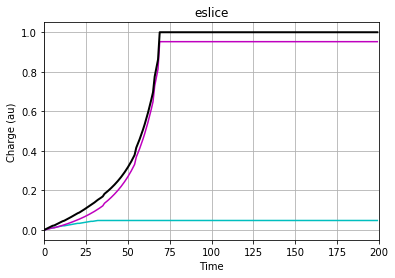

z0:  31.6666666667
0.9471
-0.0529


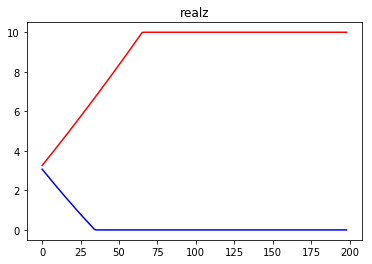

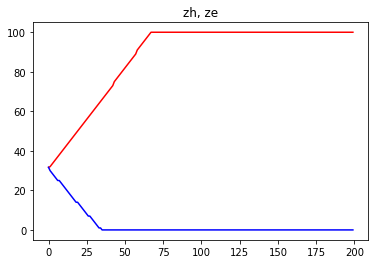

eh  1250.80658234
ee  644.703868602


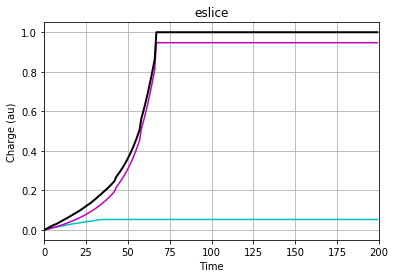

z0:  34.1025641026
0.9415
-0.0586


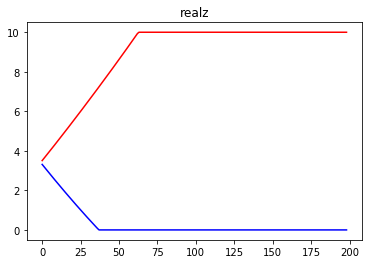

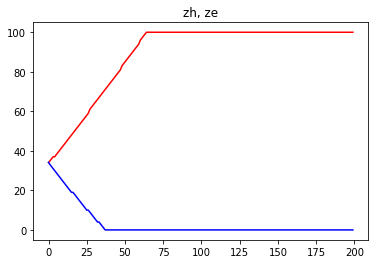

eh  1256.54940768
ee  648.183321956


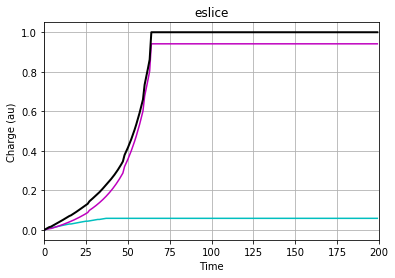

z0:  36.5384615385
0.9357
-0.0645


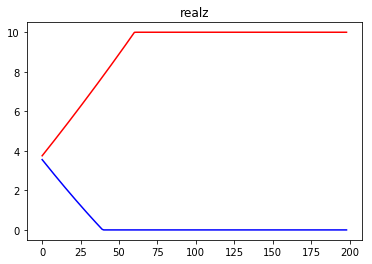

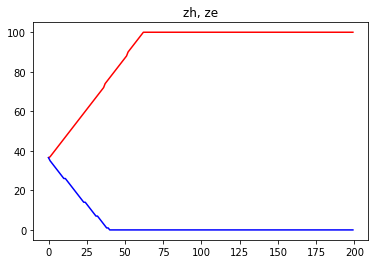

eh  1262.07005309
ee  651.823148737


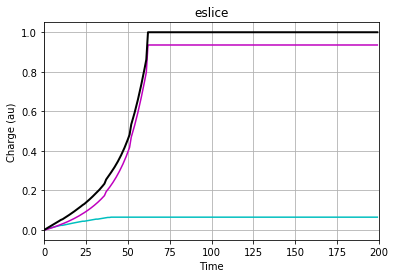

z0:  38.9743589744
0.9293
-0.0708


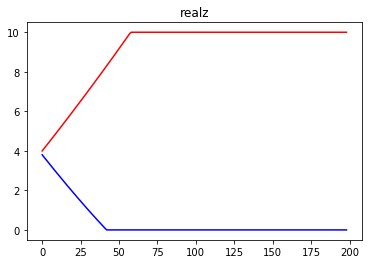

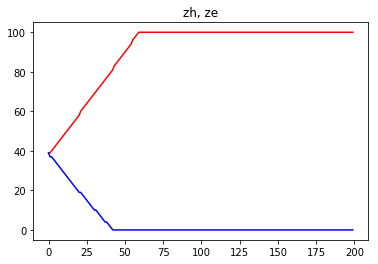

eh  1267.35864411
ee  655.61755581


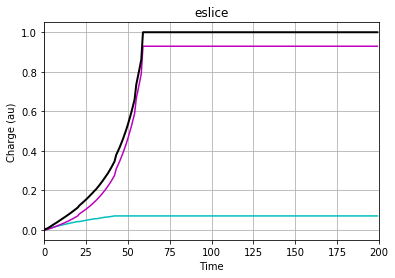

z0:  41.4102564103
0.9225
-0.0776


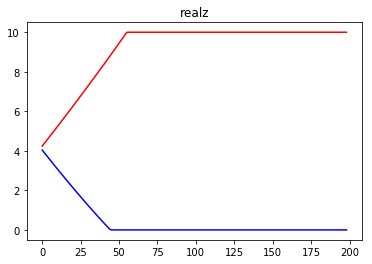

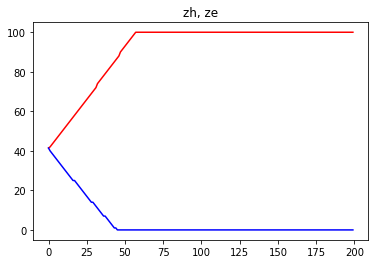

eh  1272.44753815
ee  659.560169368


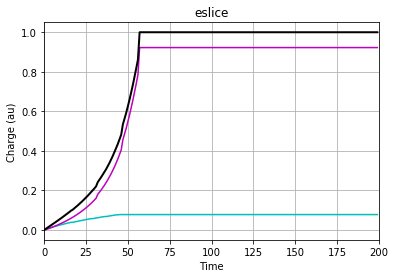

z0:  43.8461538462
0.9152
-0.0849


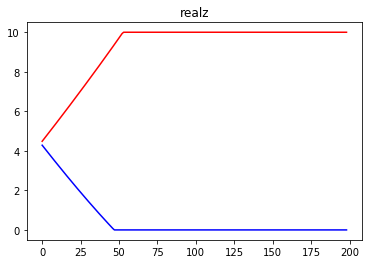

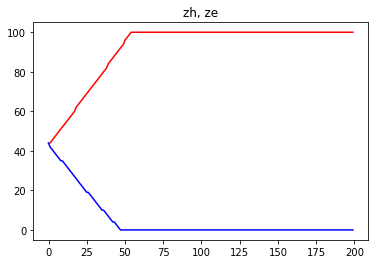

eh  1277.3231319
ee  663.647376724


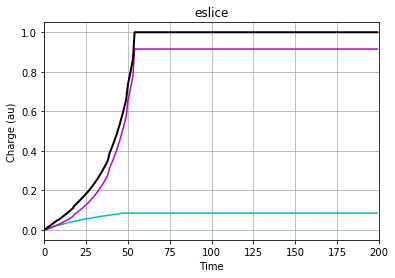

z0:  46.2820512821
0.9073
-0.0928


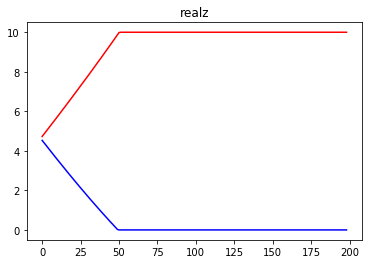

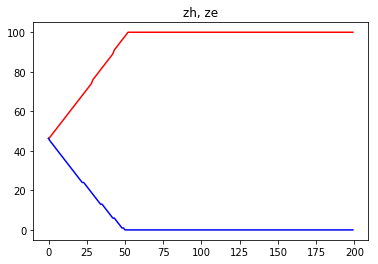

eh  1282.01208085
ee  667.874217892


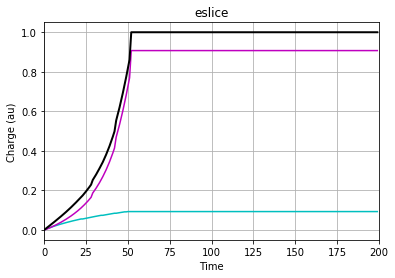

z0:  48.7179487179
0.8987
-0.1014


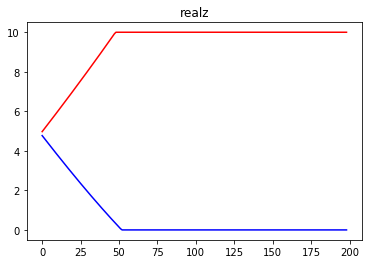

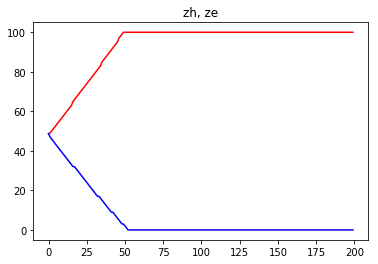

eh  1286.50538098
ee  672.239687421


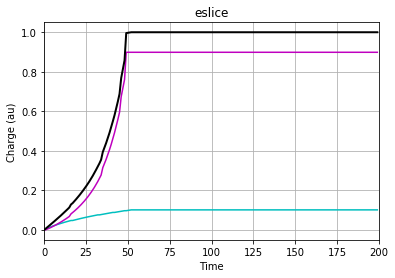

z0:  51.1538461538
0.8895
-0.1106


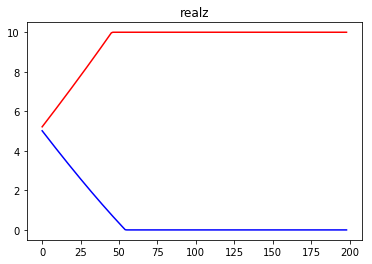

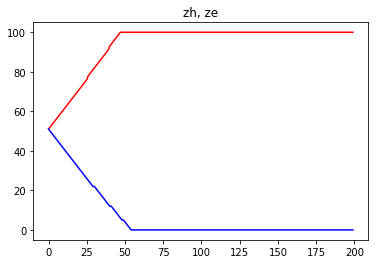

eh  1290.81676619
ee  676.739635021


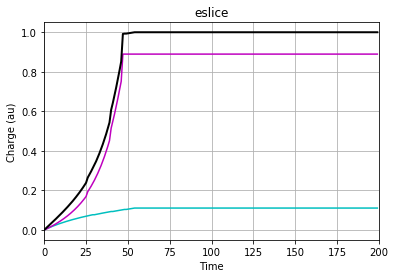

z0:  53.5897435897
0.8793
-0.1207


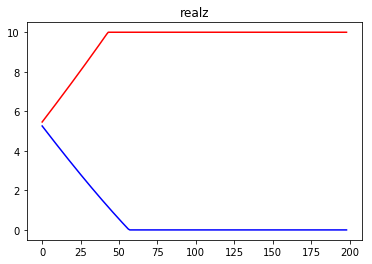

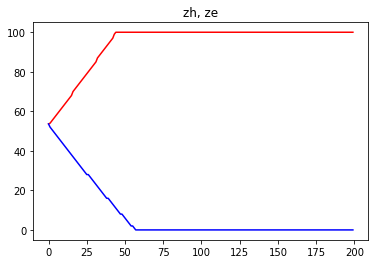

eh  1294.94898168
ee  681.375504664


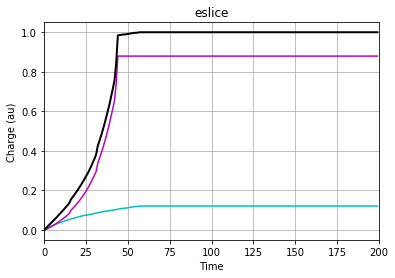

z0:  56.0256410256
0.8684
-0.1317


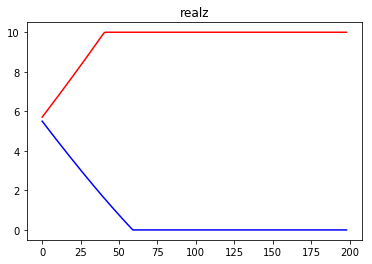

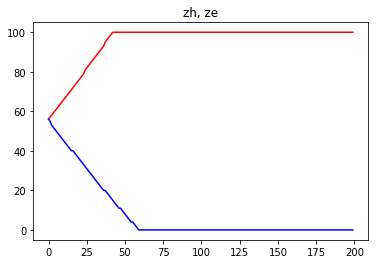

eh  1298.89664583
ee  686.14508672


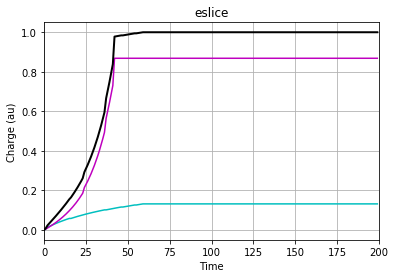

z0:  58.4615384615
0.8563
-0.1438


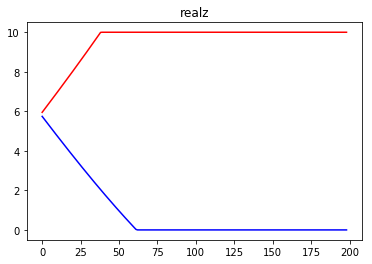

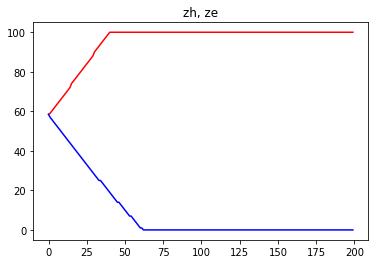

eh  1302.67669568
ee  691.049519324


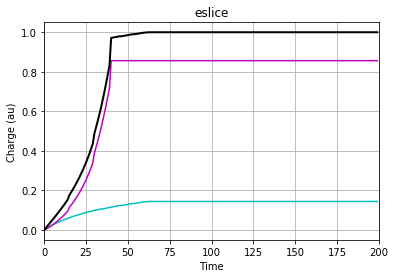

z0:  60.8974358974
0.8431
-0.157


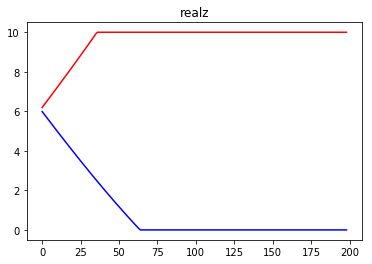

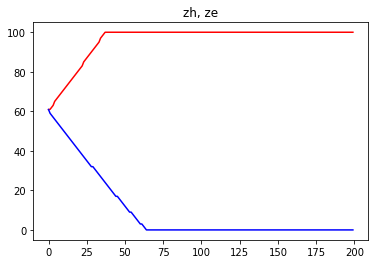

eh  1306.270308
ee  696.090609266


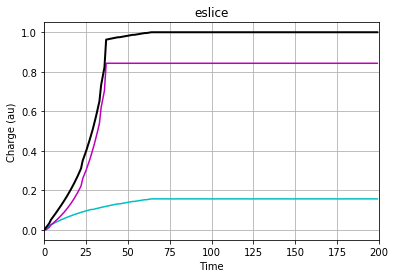

z0:  63.3333333333
0.8286
-0.1716


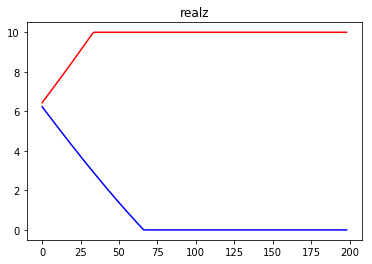

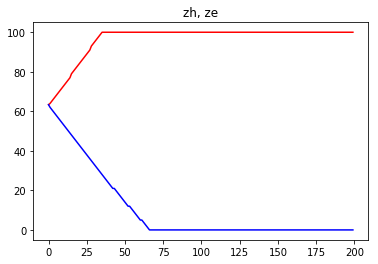

eh  1309.69176323
ee  701.268269617


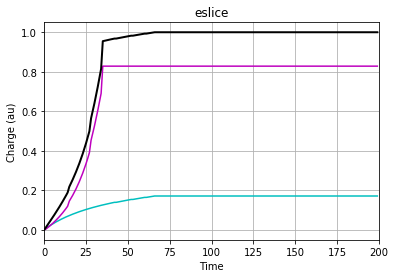

z0:  65.7692307692
0.8124
-0.1877


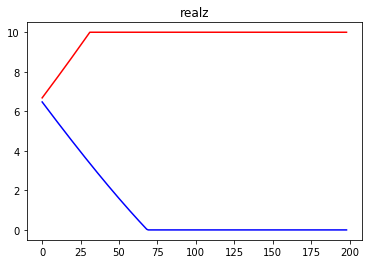

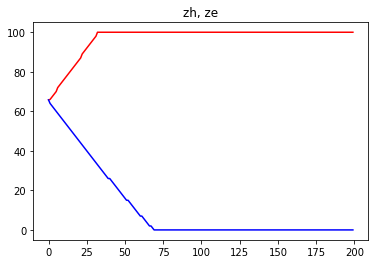

eh  1312.94063785
ee  706.586968316


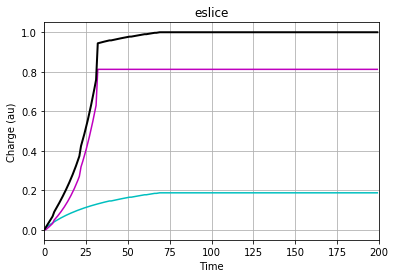

z0:  68.2051282051
0.7945
-0.2056


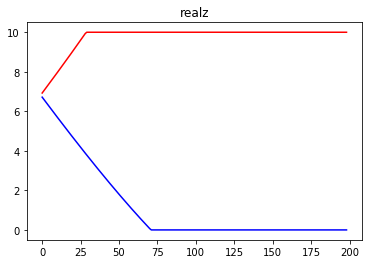

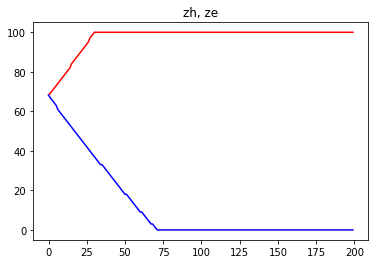

eh  1315.99865945
ee  712.048681587


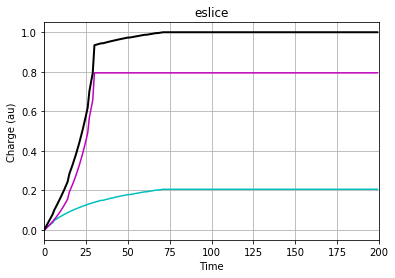

z0:  70.641025641
0.7744
-0.2257


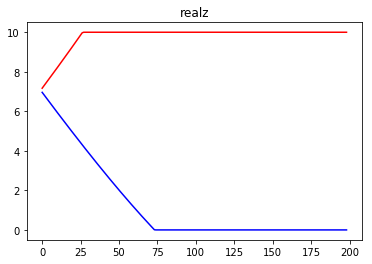

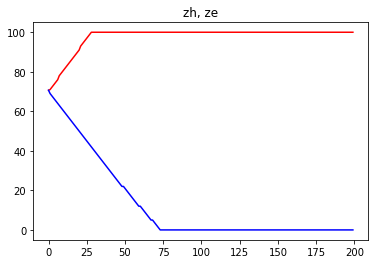

eh  1318.88076192
ee  717.655943642


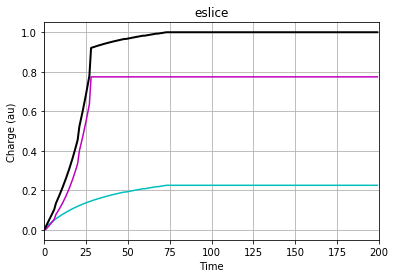

z0:  73.0769230769
0.7517
-0.2484


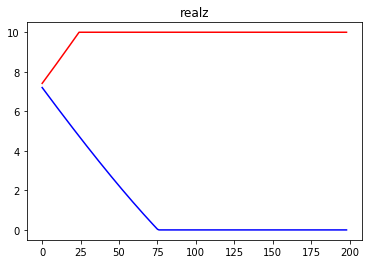

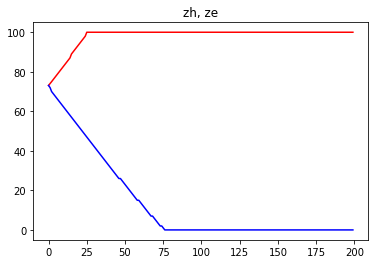

eh  1321.58001553
ee  723.414734938


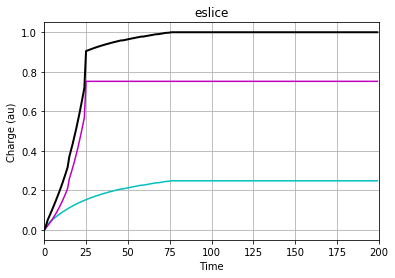

z0:  75.5128205128
0.7261
-0.274


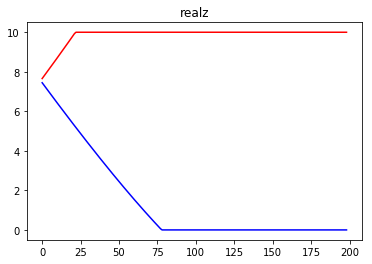

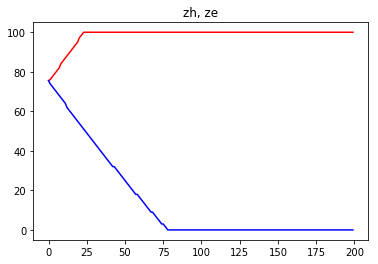

eh  1324.07878537
ee  729.328578041


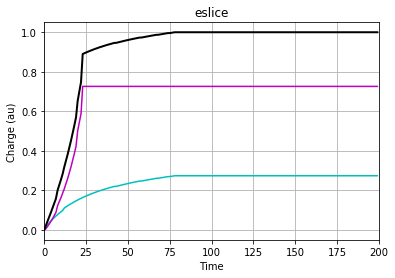

z0:  77.9487179487
0.6968
-0.3032


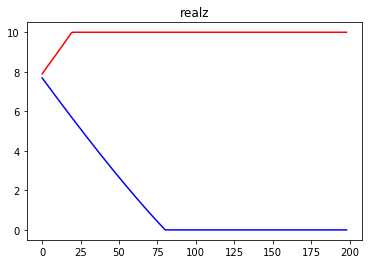

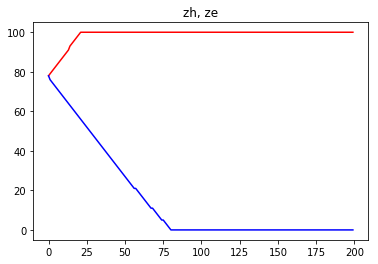

eh  1326.38754592
ee  735.40138309


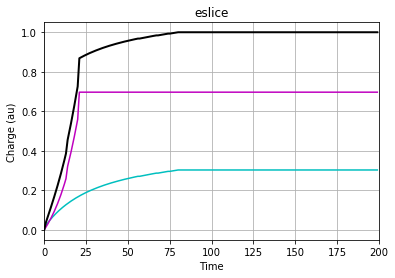

z0:  80.3846153846
0.6632
-0.3369


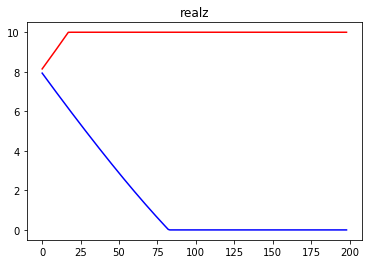

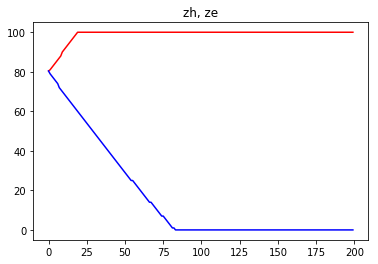

eh  1328.50033318
ee  741.640336657


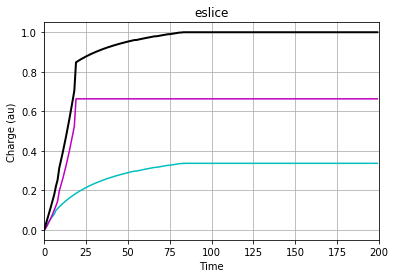

z0:  82.8205128205
0.6242
-0.3759


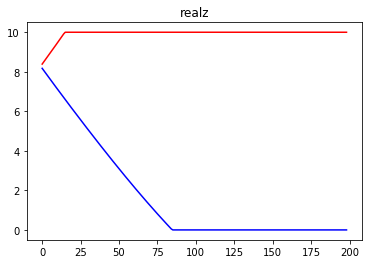

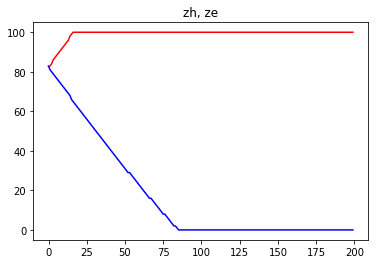

eh  1330.39555268
ee  748.051078091


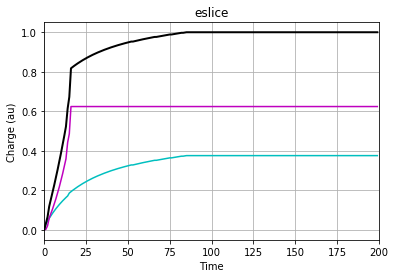

z0:  85.2564102564
0.5788
-0.4213


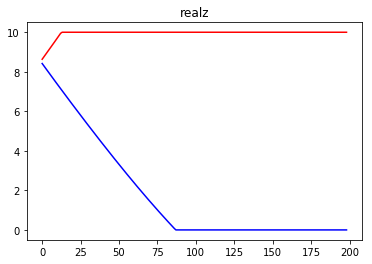

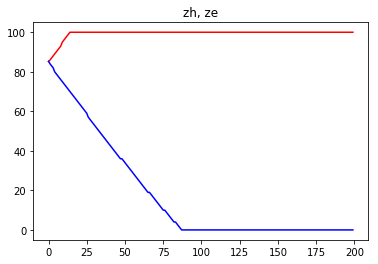

eh  1332.07844275
ee  754.638970273


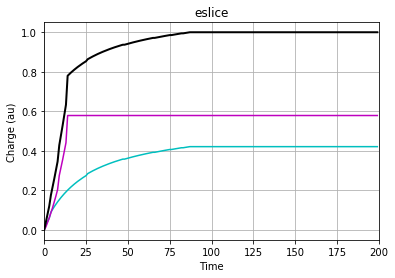

z0:  87.6923076923
0.5254
-0.4746


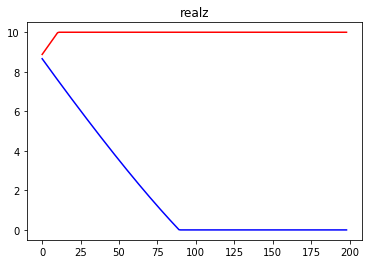

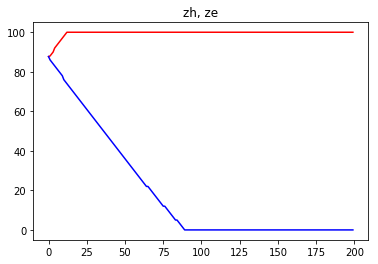

eh  1333.54274869
ee  761.410720948


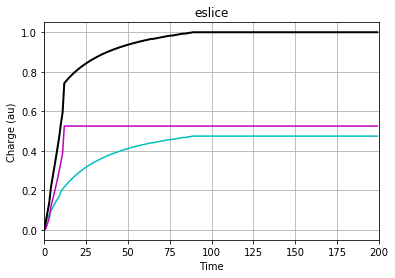

z0:  90.1282051282
0.4628
-0.5373


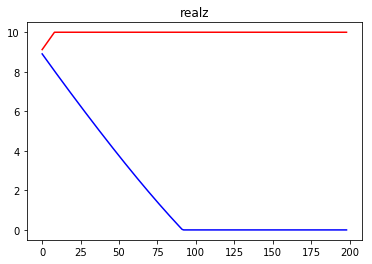

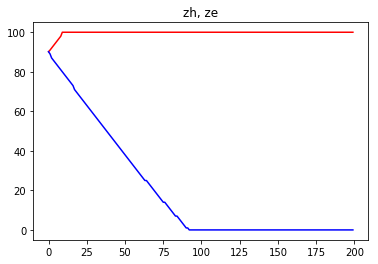

eh  1334.77764033
ee  768.374633078


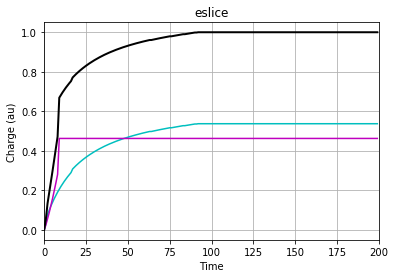

z0:  92.5641025641
0.3892
-0.611


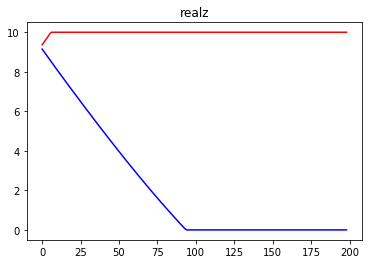

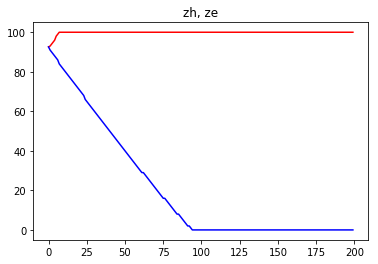

eh  1335.76211438
ee  775.537710736


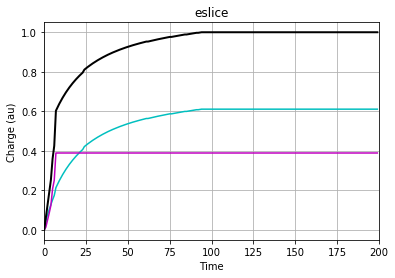

z0:  95.0
0.3036
-0.6965


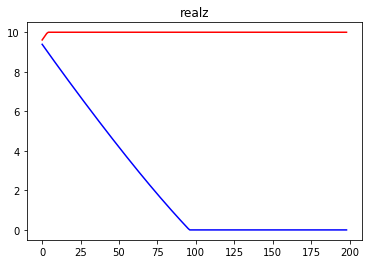

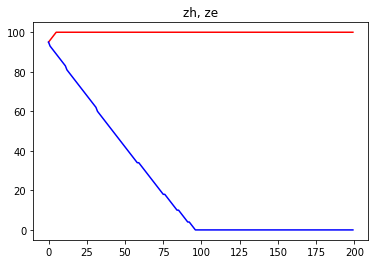

eh  1336.49842416
ee  782.906429937


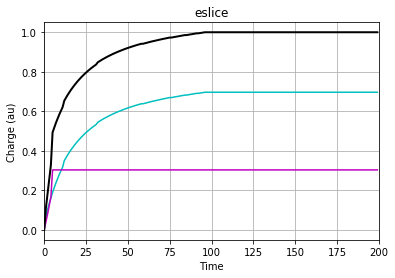

In [93]:
eps_0 = 8.85 * 10 ** (-14) # F /cm
eps = 16 * eps_0
rho = 10**10  # cm^-3
q = 1.6 * 10 ** (-19)
#Voltage = 1000 # V


# number of time steps in signal
Nt = 200
z_values = np.linspace(0, 95, 40)
all_signals = np.zeros((len(z_values), Nt))
all_signals_e = np.zeros((len(z_values), Nt))
all_signals_h = np.zeros((len(z_values), Nt))

# assume an interaction position at a given depth
depth_mm = detector_thickness_mm / 2
maxval = detector_thickness_mm / pixel_size_mm

z0 = np.int(np.floor(depth_mm / pixel_size_mm))

for i in range(0, len(z_values)):
    z0 = z_values[i]
    #z0 = np.int(np.floor(i / pixel_size_mm))
    print('z0: ',z0)
    
    # arrays which will store the induced charge signals
    Qh = np.zeros(Nt, dtype=float)
    Qe = np.zeros(Nt, dtype=float)

    # starting positions for electrons and holes
    zh_list = []
    ze_list = []
    zh_list.append(z0)
    ze_list.append(z0)
    # holes into wp
    t = 0
    w_e_vals = []
    w_h_vals = []
    zh = z0
    ze = z0
    realz_list_e = []
    realz_list_h = []
    realz = z0 * pixel_size_mm
    e_slice_list_e = []
    e_slice_list_h = []

    for t in range(1, Nt):
        x = zh_list[-1]
    
        eslice = Efunc(float(realz / pixel_size_mm)) # realz in pixel
        vh = float(efunc(eslice))
    
        realz += round(float(vh),6)

        if realz <= 0:
            realz = 0
        elif realz >= maxval *pixel_size_mm:
            realz = maxval*pixel_size_mm    
    
    
        realz_list_h.append(realz)
        
        zh = int(realz / pixel_size_mm)
        e_slice_list_h.append(eslice)
        if zh < 0:
            zh = 0
        elif zh > int(maxval):
            zh = int(maxval)
        else:
            pass
        zh_list.append(zh)

        if (zh== maxval) and (x!= maxval):
            dw = 1.0 - Wfunc(zh_list[t-1])
            w_h_vals.append(dw)
            Qh[t] = round(1.0*dw,4)
        elif (zh== maxval) and (x== maxval):
            dw = 0
            w_h_vals.append(0)
            Qh[t] = round(1.0*dw,4)
        elif (zh<=N_yelements-1):
            dw = Wfunc(zh_list[t]) - Wfunc(zh_list[t-1])
            w_h_vals.append(dw)
            Qh[t] = round(1.0*dw,4)
        
    realz = z0 * pixel_size_mm
    for t in range(1, Nt):
        x = ze_list[-1]
        ze = ze_list[-1]

        eslice = Efunc(float(realz / pixel_size_mm)) # realz in pixel
        ve = float(efunc(eslice))
    
        realz += round(float(-1 * ve),6)
    
        if realz < 0:
            realz = 0
        elif realz > maxval:
            realz = maxval
        realz_list_e.append(realz)
        ze = int(realz/ pixel_size_mm)
        e_slice_list_e.append(eslice)
    
        if ze < 0:
            ze = 0
        elif ze > int(maxval):
            ze = int(maxval)
        else:
            pass
        ze_list.append(ze)
        if (ze== 0) and (x!= 0):
            dw = 0- Wfunc(ze_list[t-1])
            w_e_vals.append(dw)
            Qe[t] = round(1.0*dw,4)
        elif (ze== 0) and (x== 0):
            dw = 0
            w_e_vals.append(0)
            Qe[t] = round(1.0*dw,4)
        elif (ze<=N_yelements-1):
            dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
            w_e_vals.append(dw)
            Qe[t] = round(1.0*dw,4)
        
    print(np.cumsum(Qh)[-1])
    print(np.cumsum(Qe)[-1])
    # electrons out of wp

    Qh = Qh
    Qe = - Qe
    # take cumulative sums
    Qsignal_h = np.cumsum(Qh)
    Qsignal_e = np.cumsum(Qe)
    Qsignal = np.cumsum(Qe + Qh)

    all_signals[i] = Qsignal 
    all_signals_e[i] = Qsignal_e 
    all_signals_h[i] = Qsignal_h
    
    plt.title('realz')
    plt.plot(realz_list_h,'r-')
    plt.plot(realz_list_e,'b-')
    plt.show()


    plt.title('zh, ze')
    plt.plot(zh_list,'r-')
    plt.plot(ze_list,'b-')
    plt.show()


    plt.title('eslice')
    print('eh ', np.mean(e_slice_list_h))
    print('ee ', np.mean(e_slice_list_e))
#plt.plot(w_e_vals,'bo')
#plt.show()
#plt.plot(w_h_vals,'ro')
#plt.show()


# plot
    plt.plot(Qsignal_e, 'c', linewidth=1.5)
    plt.plot(Qsignal_h, 'm', linewidth=1.5)
    plt.plot(Qsignal, 'k', linewidth=2)

    plt.grid("on")
#plt.ylim(0,1)
    plt.xlim(0, Nt)
#plt.tick_params(labelbottom="off")
    plt.xlabel("Time")
    plt.ylabel("Charge (au)")
#plt.legend()
    plt.show()

z0:  0.0
1.0
0.0


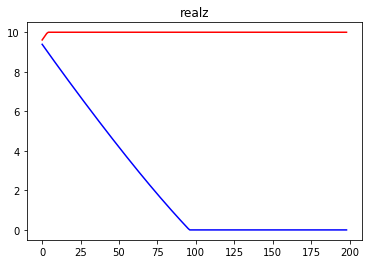

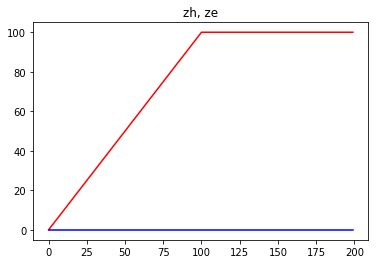

eh  1336.49842416
ee  782.906429937


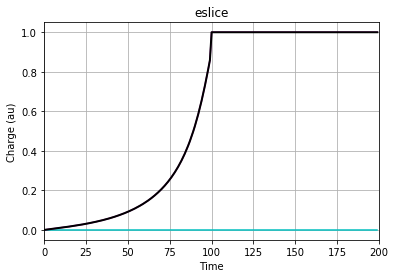

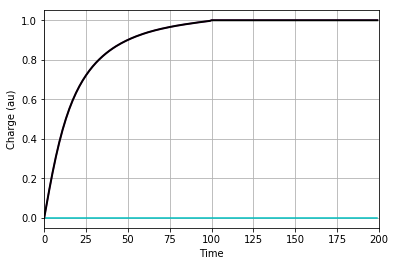

z0:  2.4358974359
0.9968
-0.0027


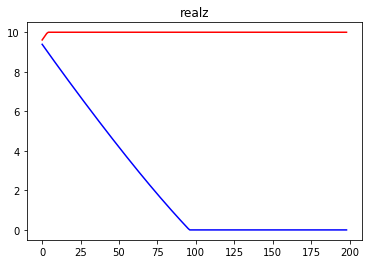

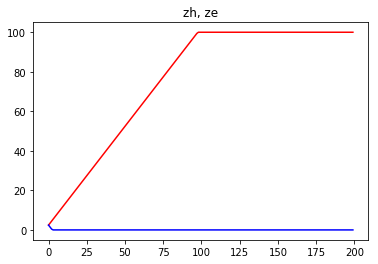

eh  1336.49842416
ee  782.906429937


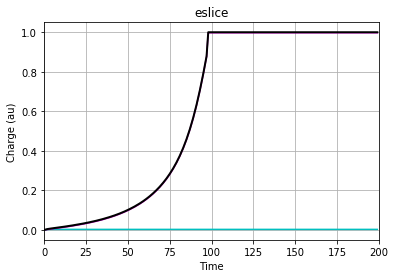

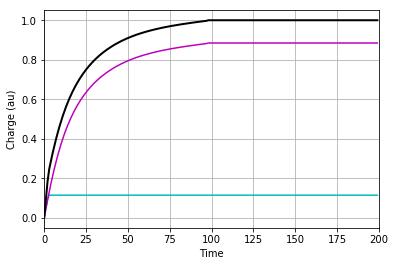

z0:  4.87179487179
0.9947
-0.0053


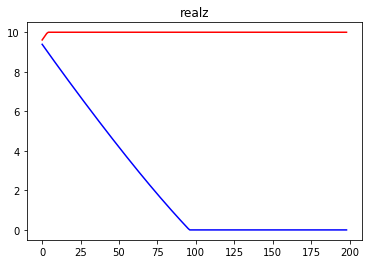

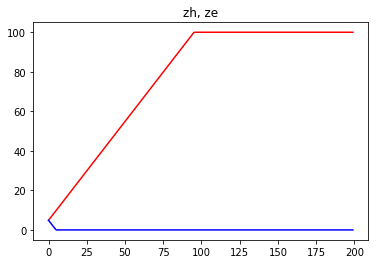

eh  1336.49842416
ee  782.906429937


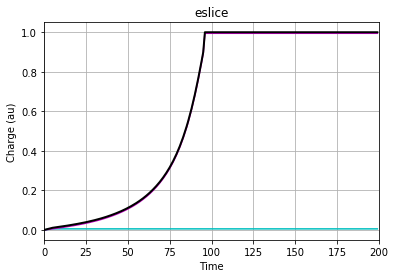

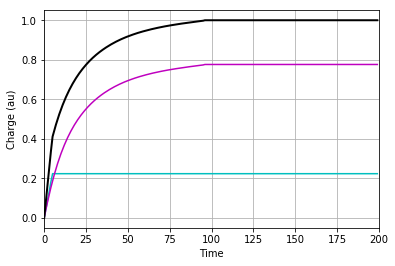

z0:  7.30769230769
0.9918
-0.008


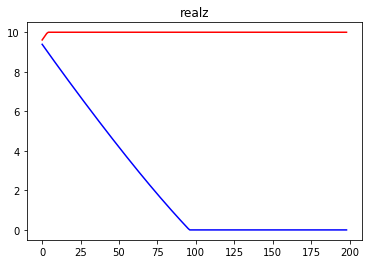

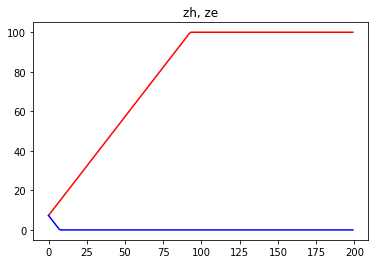

eh  1336.49842416
ee  782.906429937


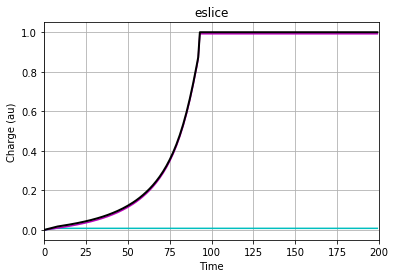

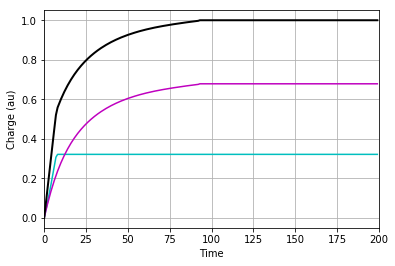

z0:  9.74358974359
0.9896
-0.0107


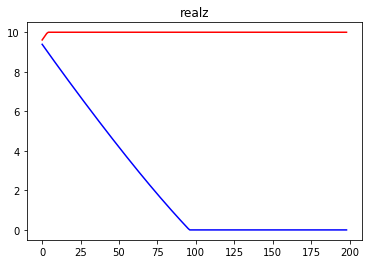

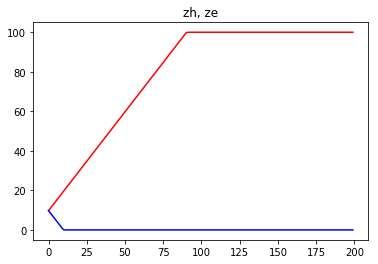

eh  1336.49842416
ee  782.906429937


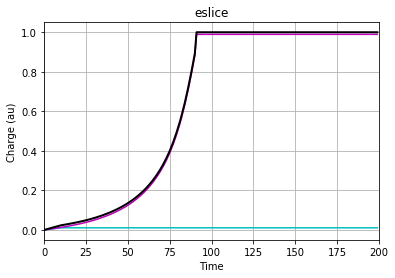

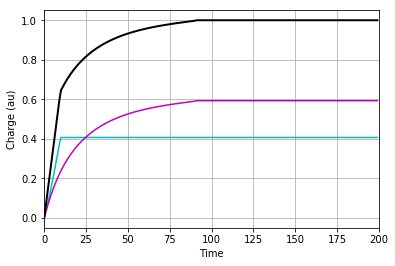

z0:  12.1794871795
0.9867
-0.0136


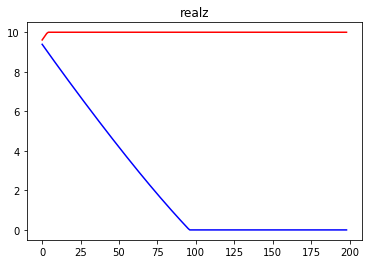

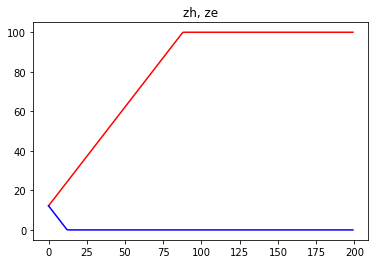

eh  1336.49842416
ee  782.906429937


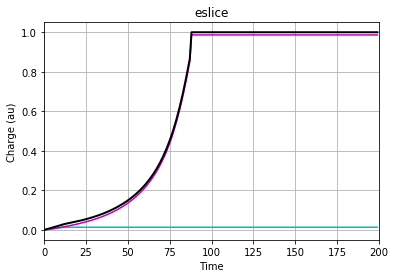

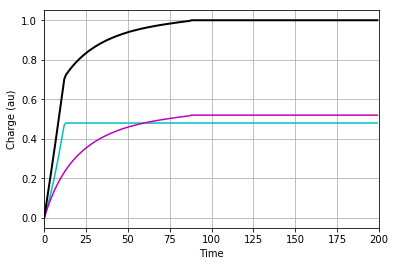

z0:  14.6153846154
0.9836
-0.0166


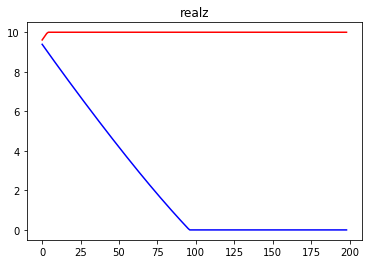

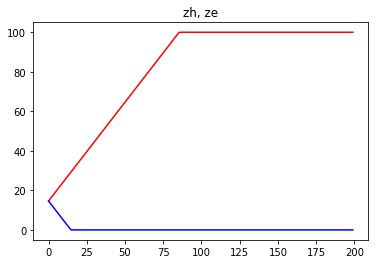

eh  1336.49842416
ee  782.906429937


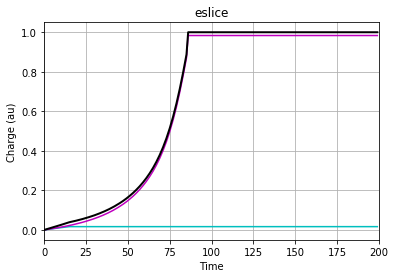

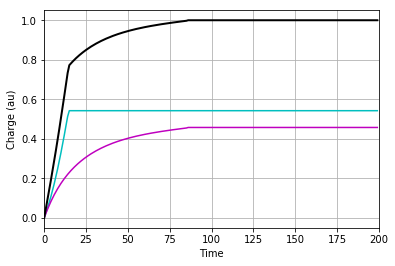

z0:  17.0512820513
0.9802
-0.0197


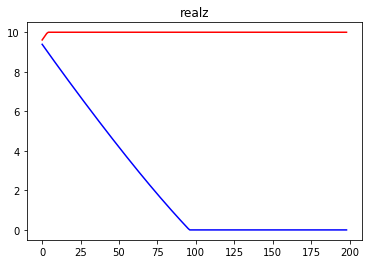

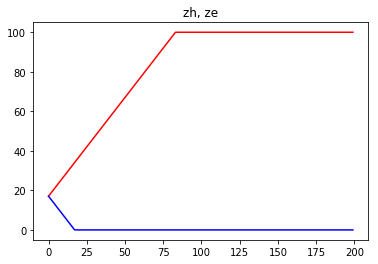

eh  1336.49842416
ee  782.906429937


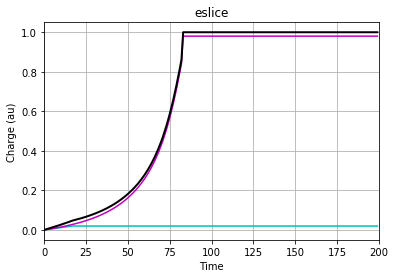

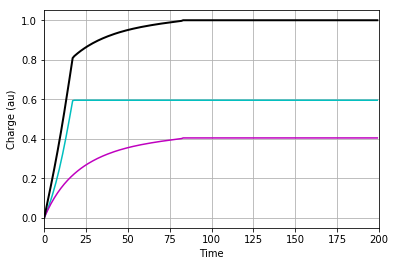

z0:  19.4871794872
0.9766
-0.023


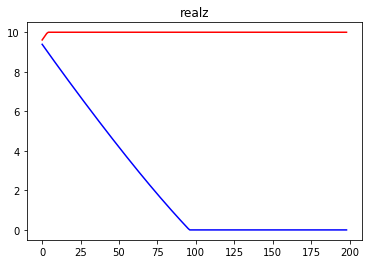

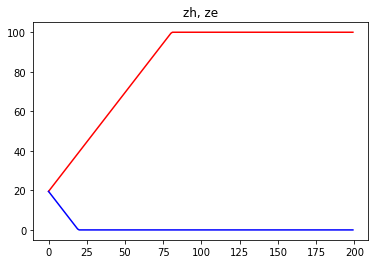

eh  1336.49842416
ee  782.906429937


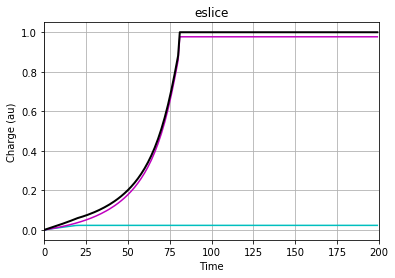

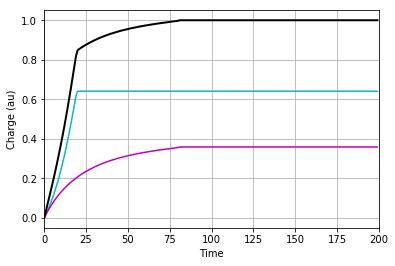

z0:  21.9230769231
0.9735
-0.0263


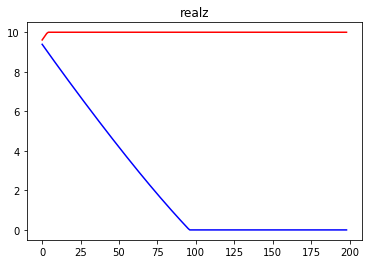

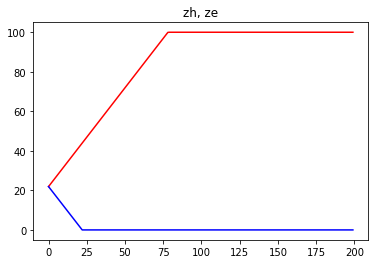

eh  1336.49842416
ee  782.906429937


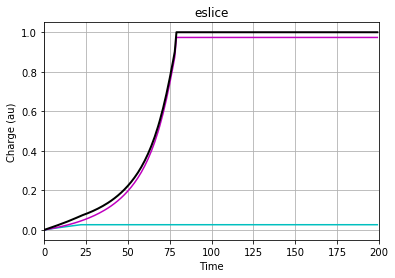

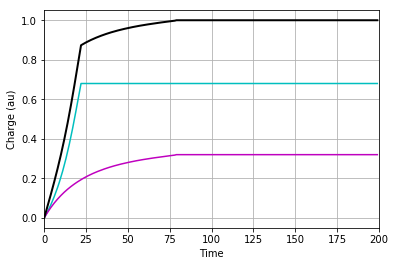

z0:  24.358974359
0.97
-0.03


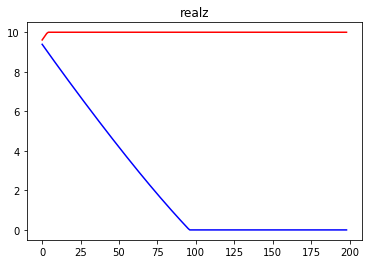

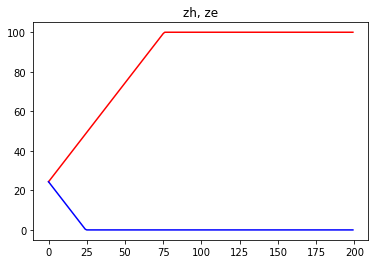

eh  1336.49842416
ee  782.906429937


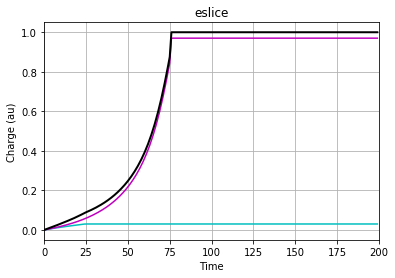

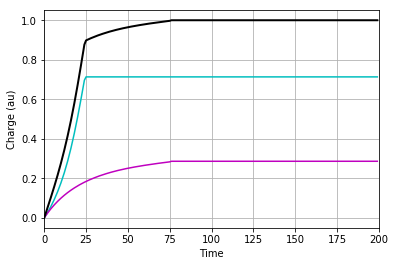

z0:  26.7948717949
0.9661
-0.034


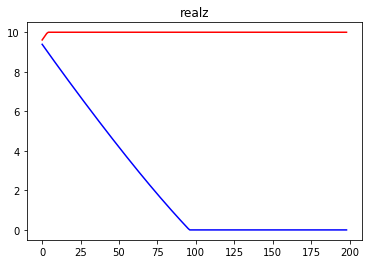

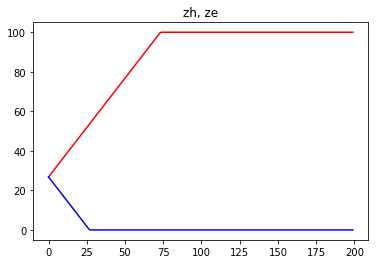

eh  1336.49842416
ee  782.906429937


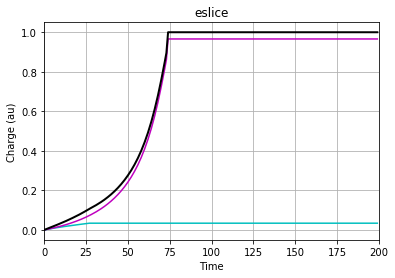

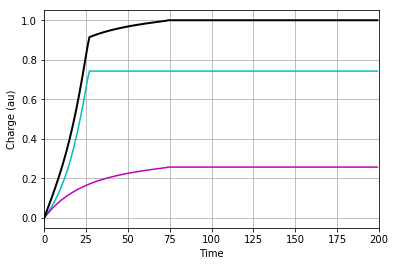

z0:  29.2307692308
0.9618
-0.0382


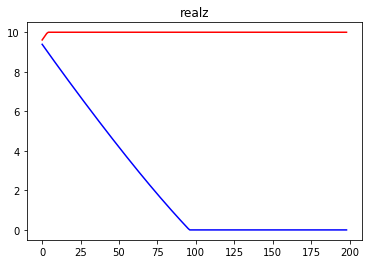

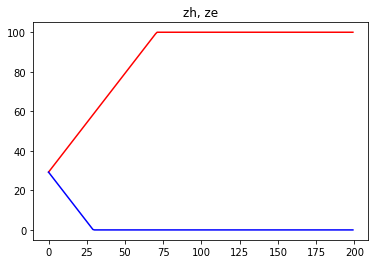

eh  1336.49842416
ee  782.906429937


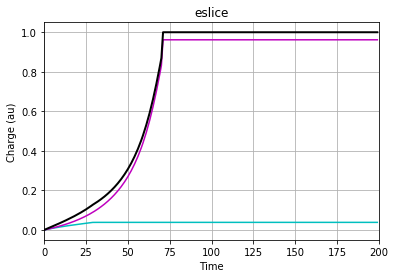

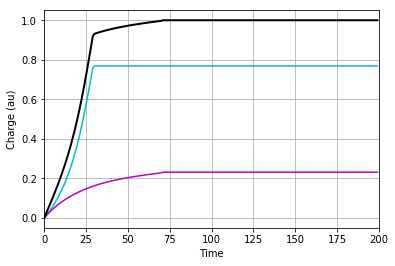

z0:  31.6666666667
0.9575
-0.0426


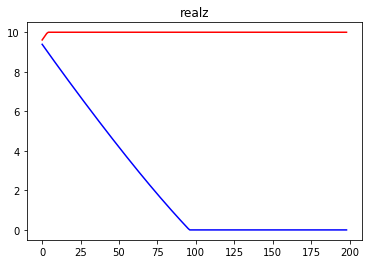

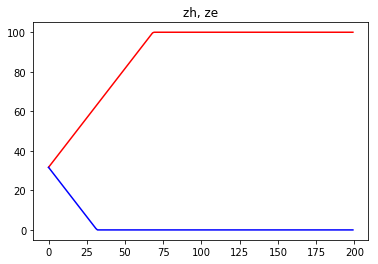

eh  1336.49842416
ee  782.906429937


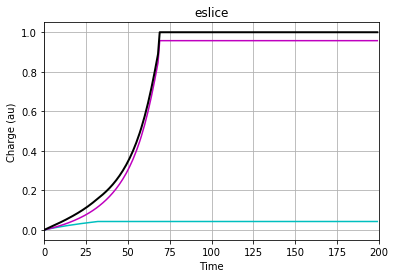

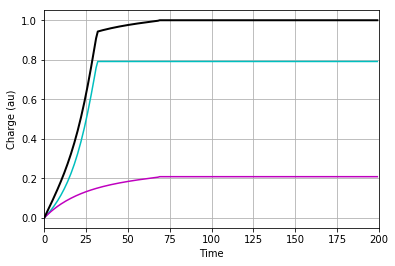

z0:  34.1025641026
0.9525
-0.0476


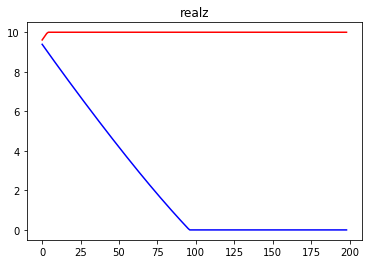

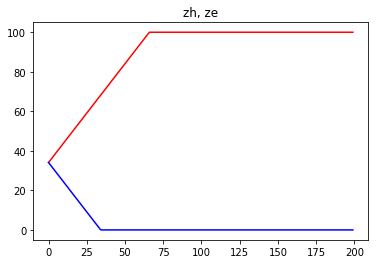

eh  1336.49842416
ee  782.906429937


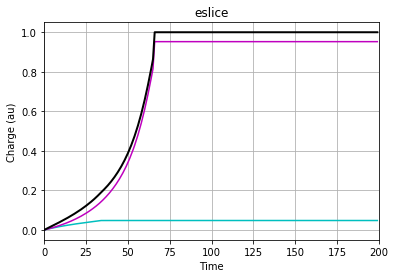

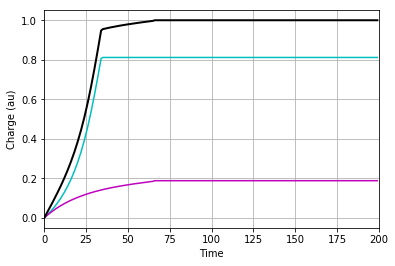

z0:  36.5384615385
0.9471
-0.0529


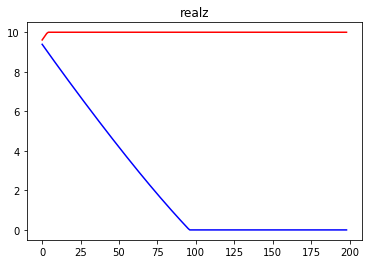

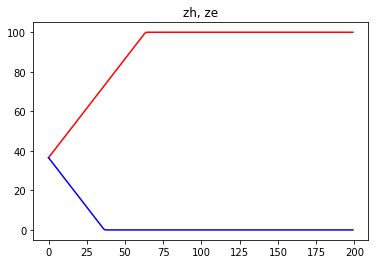

eh  1336.49842416
ee  782.906429937


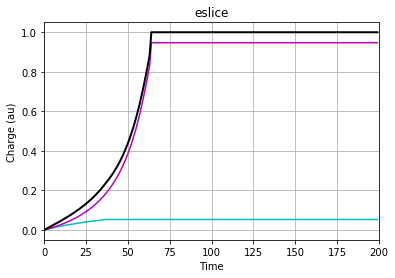

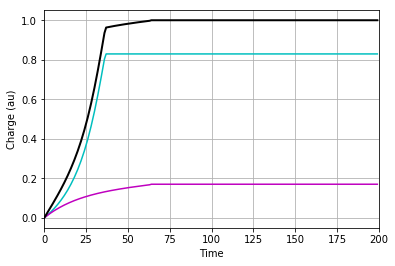

z0:  38.9743589744
0.9413
-0.0585


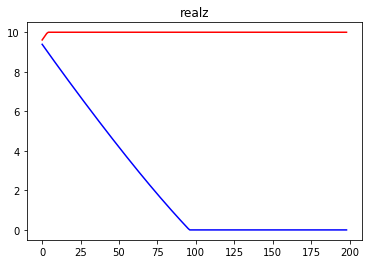

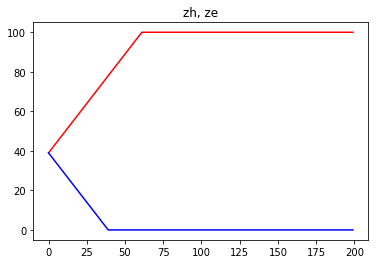

eh  1336.49842416
ee  782.906429937


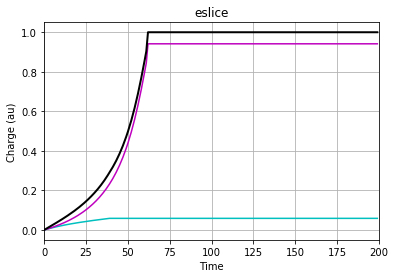

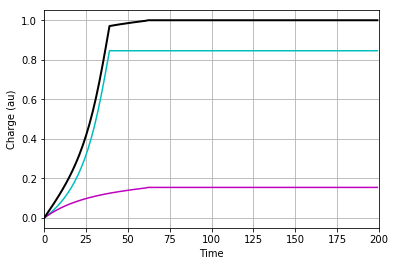

z0:  41.4102564103
0.935
-0.0647


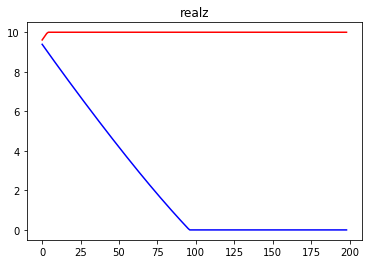

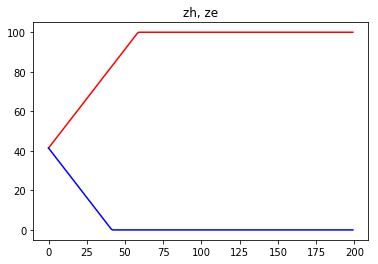

eh  1336.49842416
ee  782.906429937


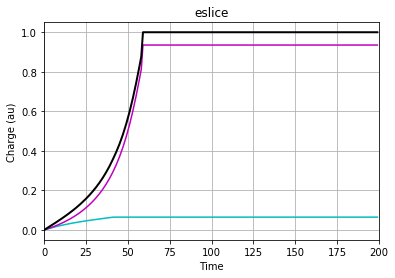

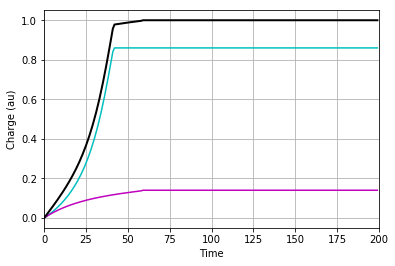

z0:  43.8461538462
0.9283
-0.0717


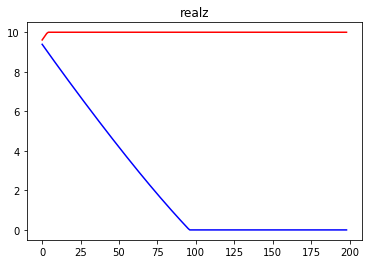

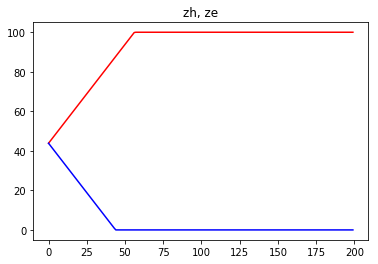

eh  1336.49842416
ee  782.906429937


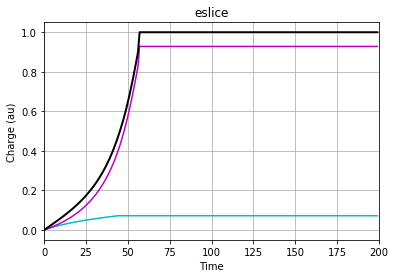

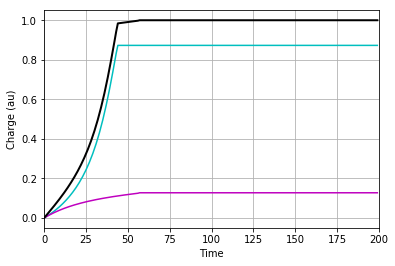

z0:  46.2820512821
0.9209
-0.079


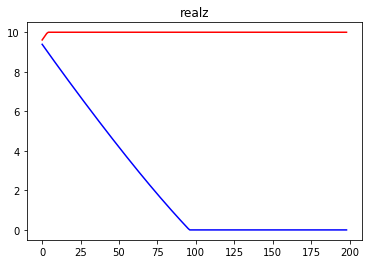

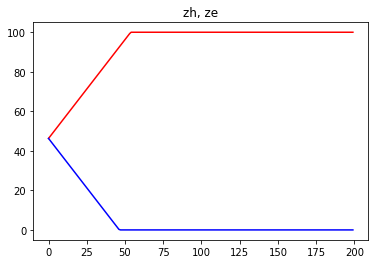

eh  1336.49842416
ee  782.906429937


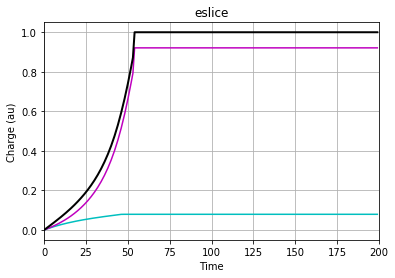

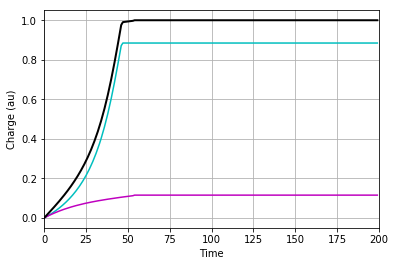

z0:  48.7179487179
0.9128
-0.0875


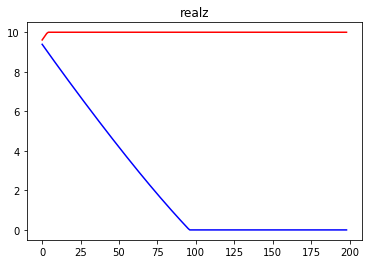

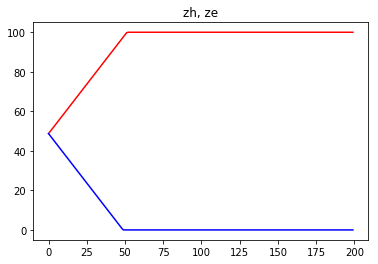

eh  1336.49842416
ee  782.906429937


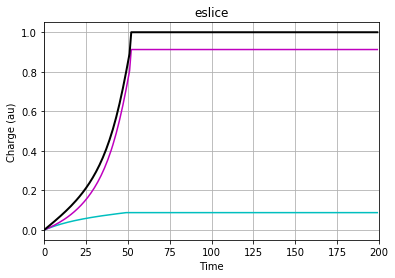

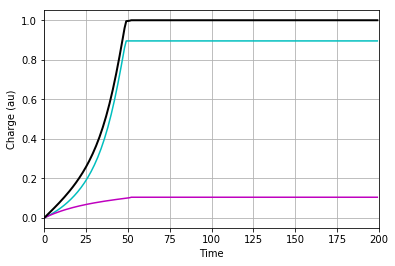

z0:  51.1538461538
0.9041
-0.0962


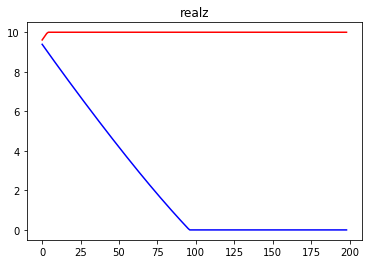

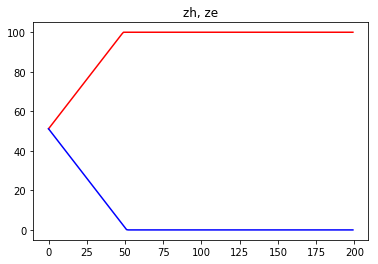

eh  1336.49842416
ee  782.906429937


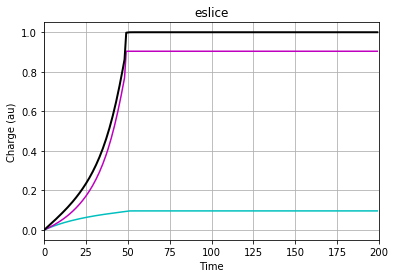

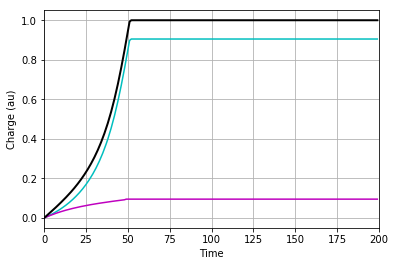

z0:  53.5897435897
0.8943
-0.1059


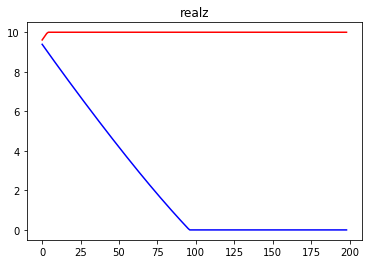

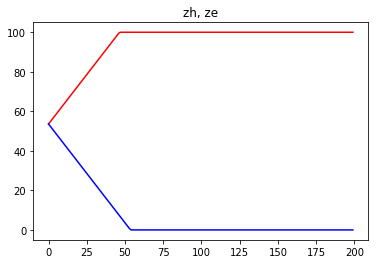

eh  1336.49842416
ee  782.906429937


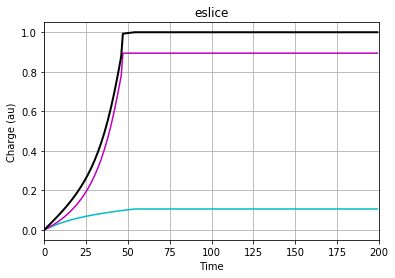

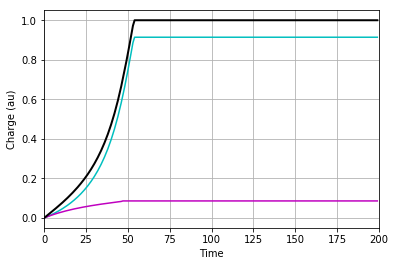

z0:  56.0256410256
0.8835
-0.1167


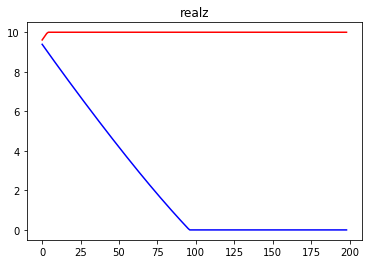

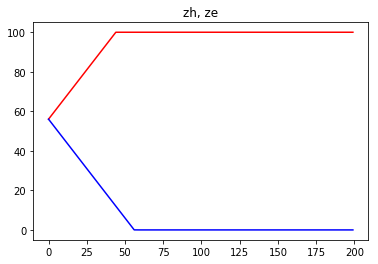

eh  1336.49842416
ee  782.906429937


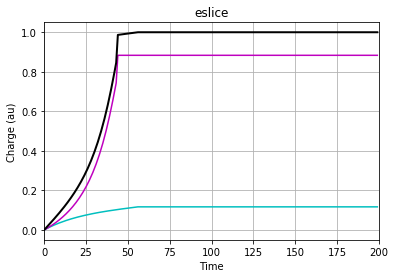

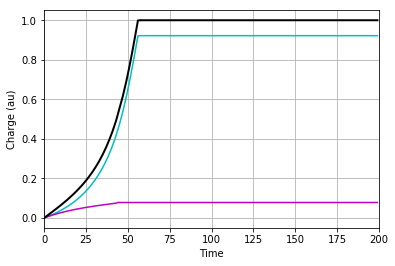

z0:  58.4615384615
0.8715
-0.1286


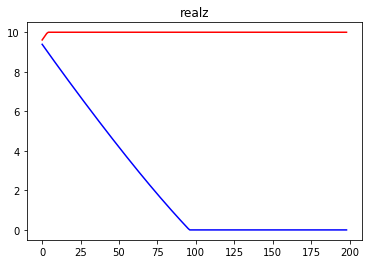

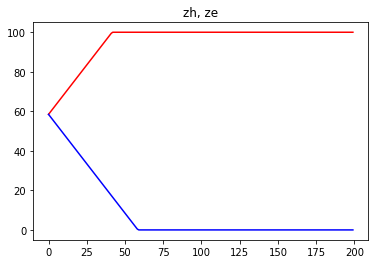

eh  1336.49842416
ee  782.906429937


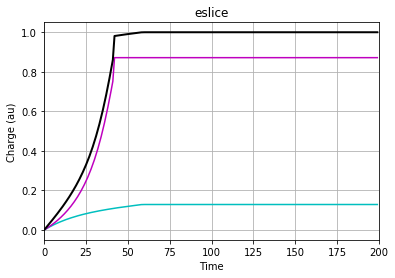

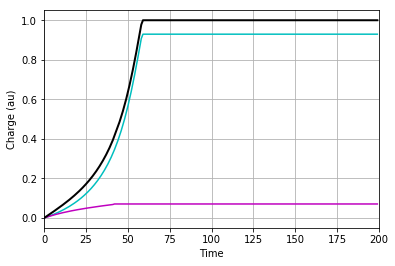

z0:  60.8974358974
0.858
-0.1418


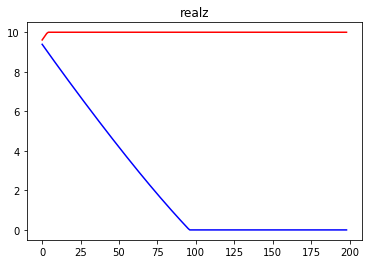

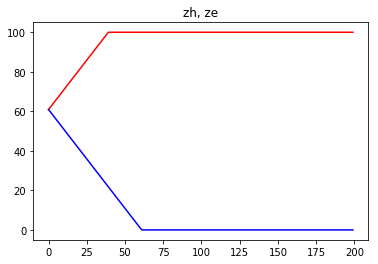

eh  1336.49842416
ee  782.906429937


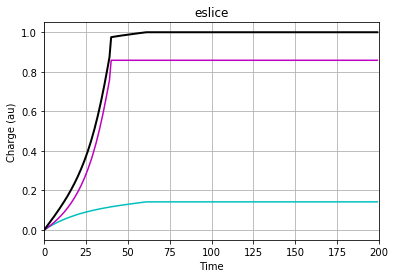

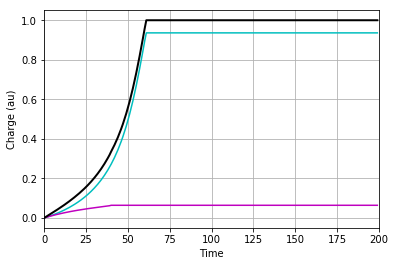

z0:  63.3333333333
0.8435
-0.1562


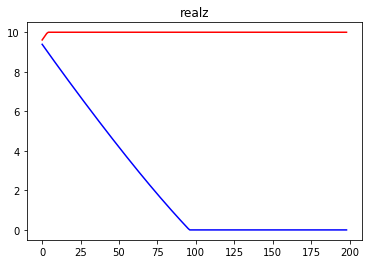

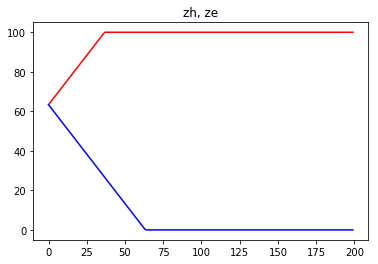

eh  1336.49842416
ee  782.906429937


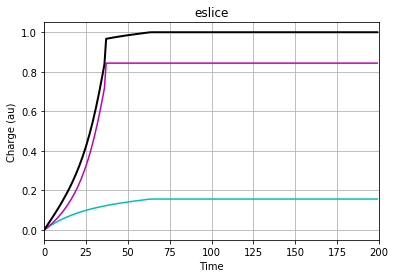

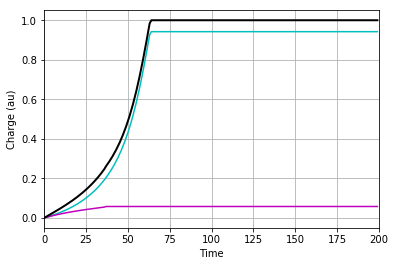

z0:  65.7692307692
0.8272
-0.1728


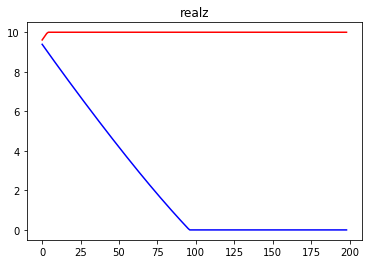

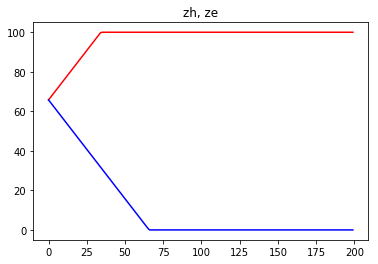

eh  1336.49842416
ee  782.906429937


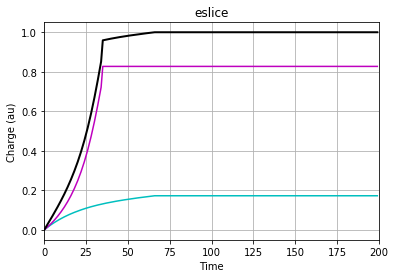

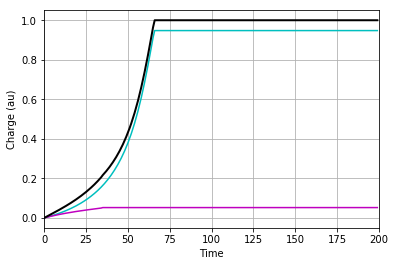

z0:  68.2051282051
0.809
-0.1909


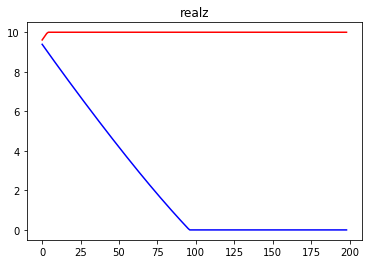

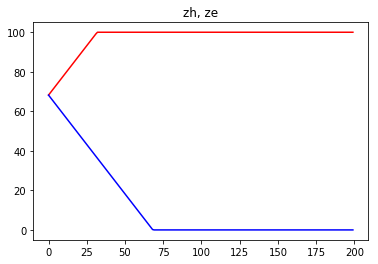

eh  1336.49842416
ee  782.906429937


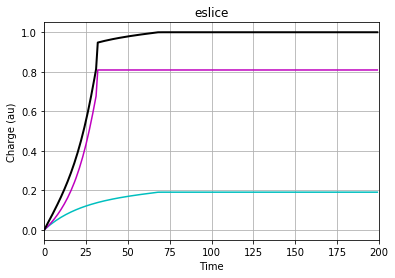

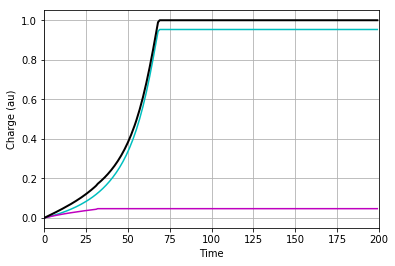

z0:  70.641025641
0.7885
-0.2115


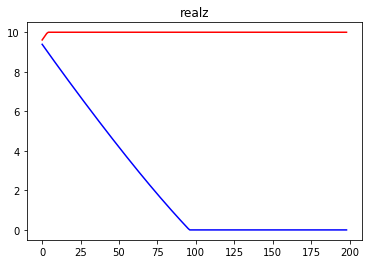

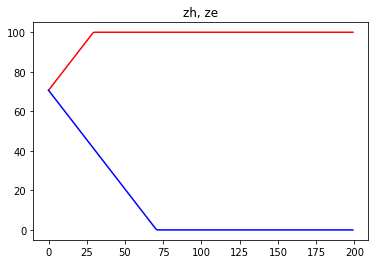

eh  1336.49842416
ee  782.906429937


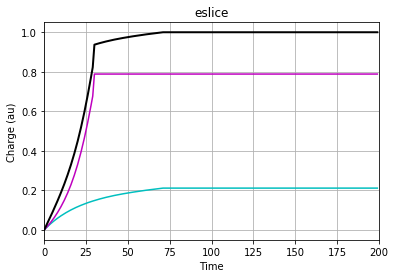

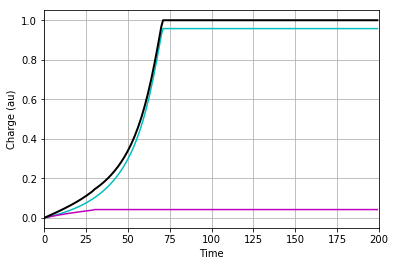

z0:  73.0769230769
0.7657
-0.2346


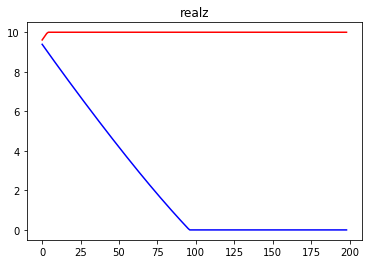

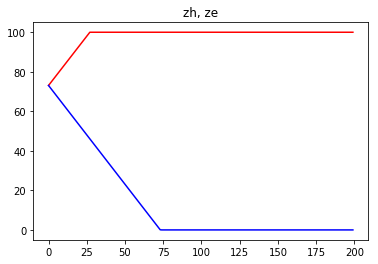

eh  1336.49842416
ee  782.906429937


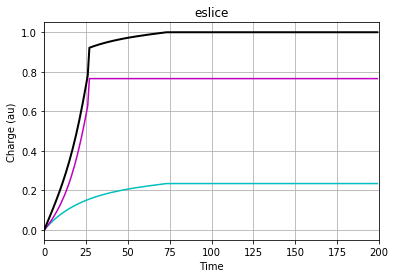

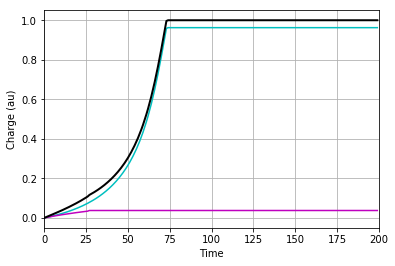

z0:  75.5128205128
0.7396
-0.2603


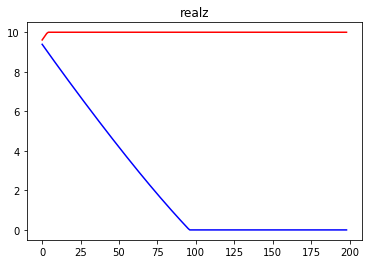

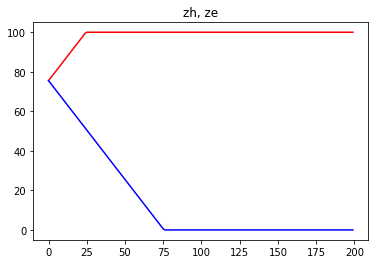

eh  1336.49842416
ee  782.906429937


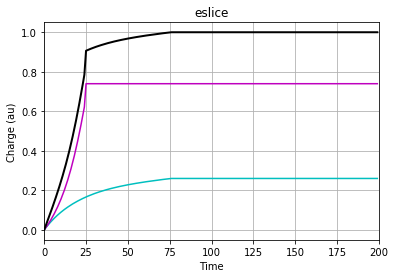

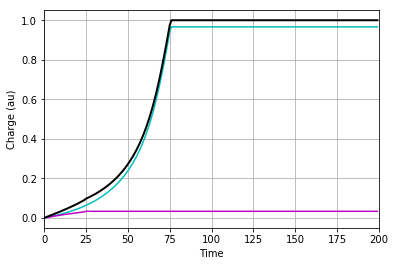

z0:  77.9487179487
0.7097
-0.2906


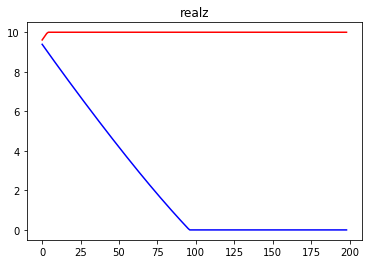

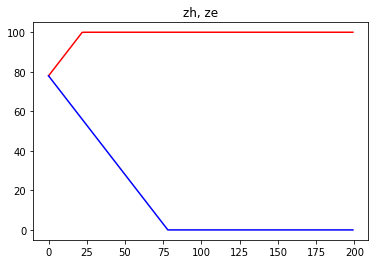

eh  1336.49842416
ee  782.906429937


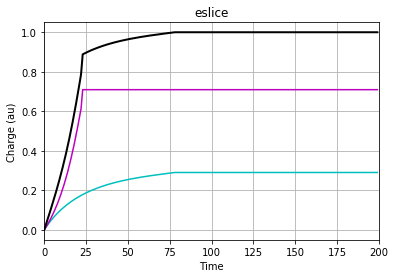

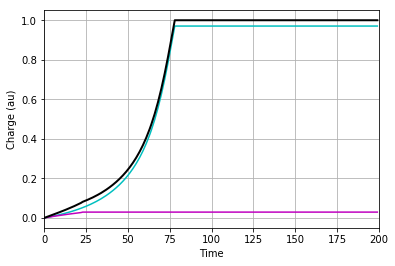

z0:  80.3846153846
0.675
-0.3247


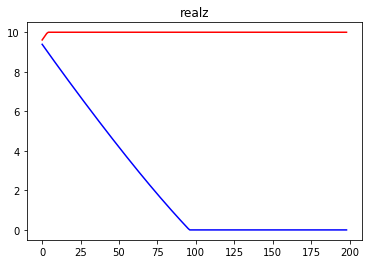

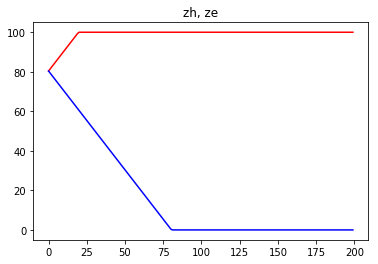

eh  1336.49842416
ee  782.906429937


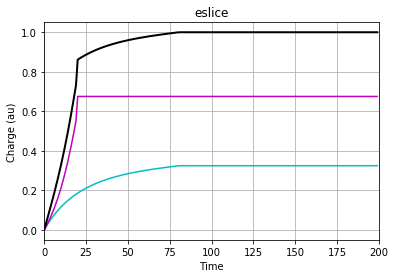

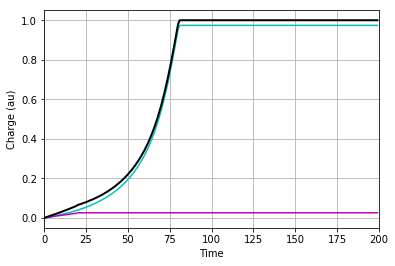

z0:  82.8205128205
0.6354
-0.3646


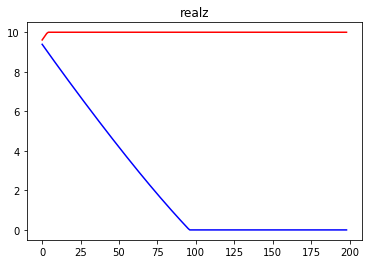

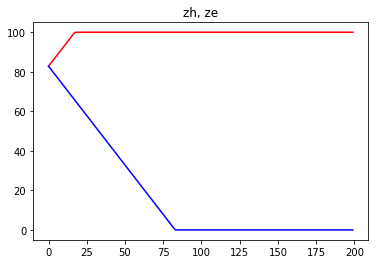

eh  1336.49842416
ee  782.906429937


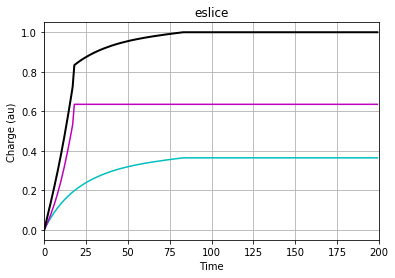

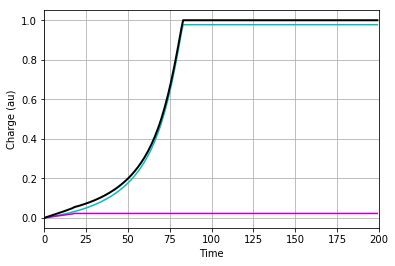

z0:  85.2564102564
0.5894
-0.4107


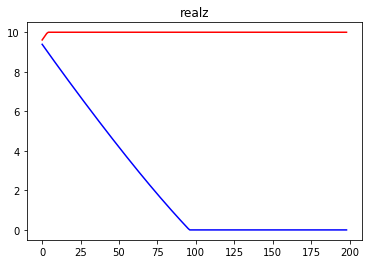

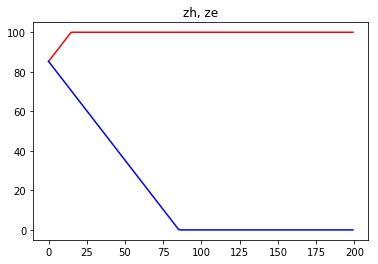

eh  1336.49842416
ee  782.906429937


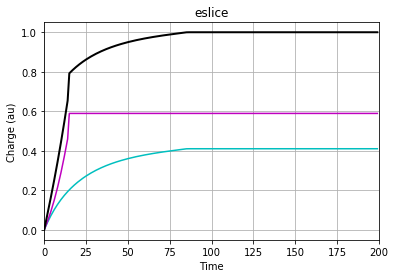

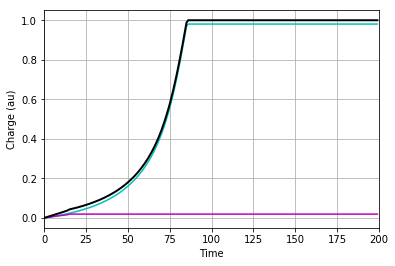

z0:  87.6923076923
0.5352
-0.4651


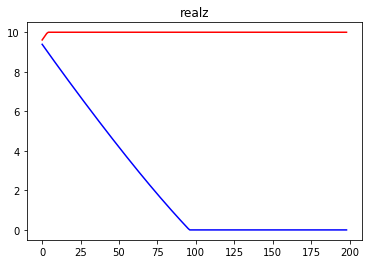

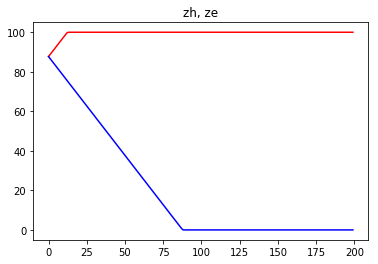

eh  1336.49842416
ee  782.906429937


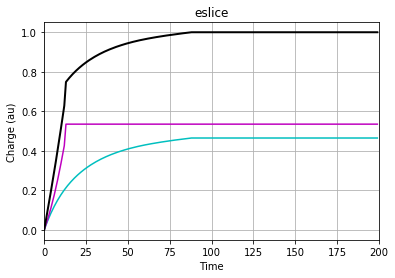

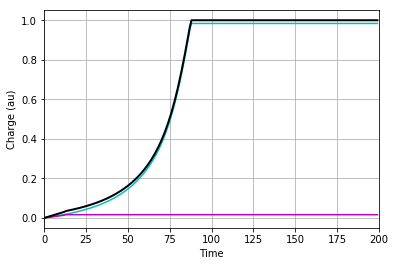

z0:  90.1282051282
0.4716
-0.5286


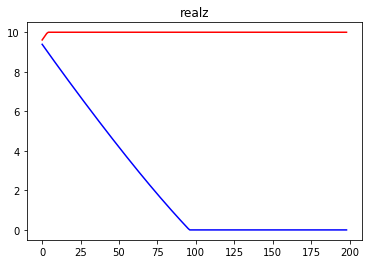

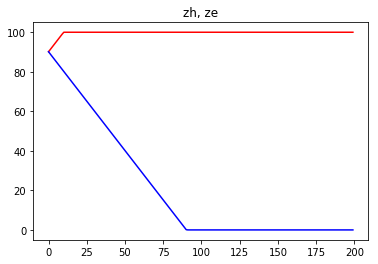

eh  1336.49842416
ee  782.906429937


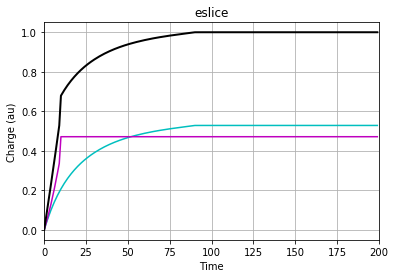

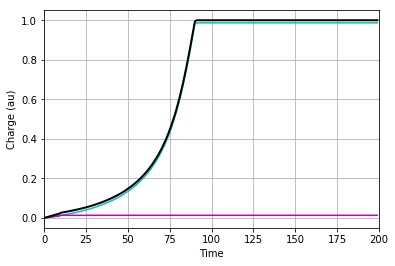

z0:  92.5641025641
0.3969
-0.6034


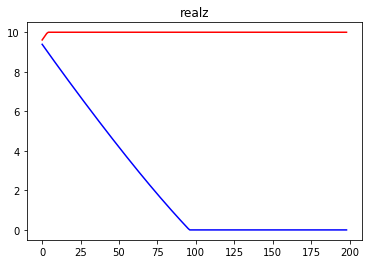

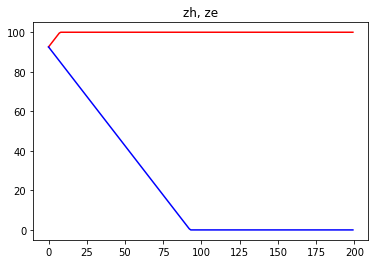

eh  1336.49842416
ee  782.906429937


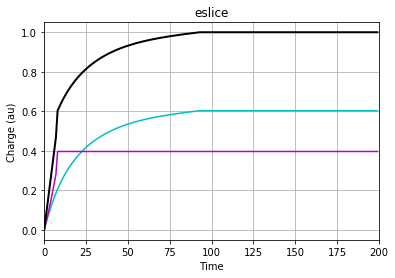

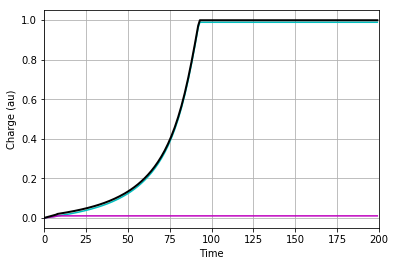

z0:  95.0
0.3099
-0.6901


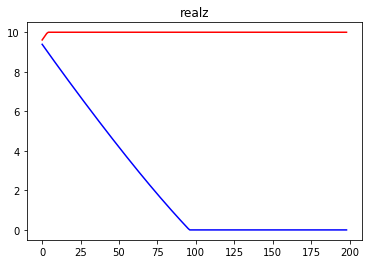

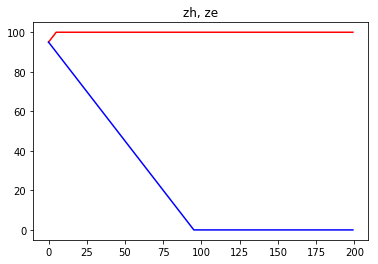

eh  1336.49842416
ee  782.906429937


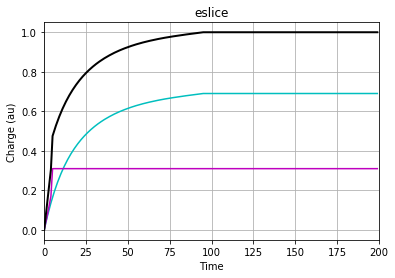

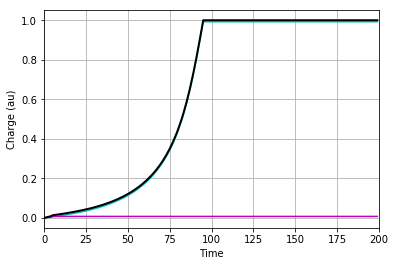

In [146]:
eps_0 = 8.85 * 10 ** (-14) # F /cm
eps = 16 * eps_0
rho = 10**10  # cm^-3
q = 1.6 * 10 ** (-19)
#Voltage = 1000 # V


# number of time steps in signal
Nt = 200
z_values = np.linspace(0, 95, 40)
all_signals_1 = np.zeros((len(z_values), Nt))
all_signals_e_1 = np.zeros((len(z_values), Nt))
all_signals_h_1 = np.zeros((len(z_values), Nt))
all_signals_2 = np.zeros((len(z_values), Nt))
all_signals_e_2 = np.zeros((len(z_values), Nt))
all_signals_h_2 = np.zeros((len(z_values), Nt))

# assume an interaction position at a given depth
depth_mm = detector_thickness_mm / 2
maxval = detector_thickness_mm / pixel_size_mm

z0 = np.int(np.floor(depth_mm / pixel_size_mm))

for i in range(0, len(z_values)):
    z0 = z_values[i]
    #z0 = np.int(np.floor(i / pixel_size_mm))
    print('z0: ',z0)
    
    Qh1 = np.zeros(Nt, dtype=float) # 1 = top, 2 = bottom
    Qe1 = np.zeros(Nt, dtype=float)
    Qh2 = np.zeros(Nt, dtype=float)
    Qe2 = np.zeros(Nt, dtype=float)    

    # starting positions for electrons and holes
    zh_list = []
    ze_list = []
    zh_list.append(z0)
    ze_list.append(z0)
    # holes into wp
    t = 0
    w_e_vals = []
    w_h_vals = []
    zh = z0
    ze = z0
    zh_list
    for t in range(1, Nt):
        #print(len(Eslice))
        #print(x)
        x = zh_list[-1]
        zh = zh_list[-1]
        eslice = Efunc(x)
        muh = float(hfunc(eslice))
        vh = muh * eslice
        zh = zh + 1
        #zh = np.int(zh + np.floor(vh / pixel_size_mm))

        #print(x, Eslice[x])
        #print(mue, muh)
        #print(vh)
        #print('zh', zh)
    
        if zh < 0:
            zh = 0
            #print('zero ', zh)
        elif zh > int(maxval):
            zh = int(maxval)
            #print('max ', zh)
        else:
            pass
        #print('zh1', zh)
        zh_list.append(zh)
        #print('=======')
        #print(zh_list)
        #print('zh2', zh)
        #x_list.append(x_list[-1] + np.floor(vh))
        if (zh== maxval) and (x!= maxval):
            dw = 1.0 - W1func(zh_list[t-1])
            w_h_vals.append(dw)
            Qh1[t] = round(1.0*dw,4)
            dw = 0 - W2func(zh_list[t-1])
            w_h_vals.append(dw)
            Qh2[t] = round(1.0*dw,4)
            #print(np.cumsum(Qh)[-1])
        elif (zh== maxval) and (x== maxval):
            dw = 0
            w_h_vals.append(0)
            Qh1[t] = round(1.0*dw,4)
            Qh2[t] = round(1.0*dw,4)
            #print(np.cumsum(Qh)[-1])
        elif (zh<=N_yelements-1):
            dw = W1func(zh_list[t]) - W1func(zh_list[t-1])
            #w_h_vals.append(dw)
            #w_h_vals.append(Wfunc(zh_list[t-1]))
            w_h_vals.append(dw)
            Qh1[t] = round(1.0*dw,4)
            dw = W2func(zh_list[t]) - W2func(zh_list[t-1])
            #w_h_vals.append(dw)
            #w_h_vals.append(Wfunc(zh_list[t-1]))
            w_h_vals.append(dw)
            Qh2[t] = round(1.0*dw,4)
            #print(np.cumsum(Qh)[-1])
    for t in range(1, Nt):
        #print(x)
        x = ze_list[-1]
        ze = ze_list[-1]
       # print(x)
        #print('zh0', zh)
        eslice = Efunc(x)
        mue = float(efunc(eslice))
        ve = mue * eslice
        ze = ze - 1
       # print('ze ', ze)
        if ze < 0:
            ze = 0
        elif ze > int(maxval):
            ze = int(maxval)
        else:
            pass
       # print('ze1 ', ze)
        ze_list.append(ze)
        if (ze== 0) and (x!= 0):
            dw = 0- W1func(ze_list[t-1])
            #print('e1 ', Wfunc(ze_list[t]))
            #assert Wfunc(ze_list[t]) == 0
            #w_e_vals.append(dw)
            w_e_vals.append(dw)
            Qe1[t] = round(1.0*dw,4)
            
            dw = 1.0- W2func(ze_list[t-1])
            #print('e1 ', Wfunc(ze_list[t]))
            #assert Wfunc(ze_list[t]) == 0
            #w_e_vals.append(dw)
            w_e_vals.append(dw)
            Qe2[t] = round(1.0*dw,4)
            #print(np.cumsum(Qe)[-1])
        elif (ze== 0) and (x== 0):
            dw = 0
            #print('e2 ', Wfunc(ze_list[t]))
            #assert Wfunc(ze_list[t]) == 0
            w_e_vals.append(0)
            Qe1[t] = round(1.0*dw,4)
            dw = 0
            #print('e2 ', Wfunc(ze_list[t]))
            #assert Wfunc(ze_list[t]) == 0
            w_e_vals.append(0)
            Qe2[t] = round(1.0*dw,4)
            #print(np.cumsum(Qe)[-1])
        elif (ze<=N_yelements-1):
            dw = W1func(ze_list[t]) - W1func(ze_list[t-1])
            #w_e_vals.append(Wfunc(zh_list[t]))
            #w_e_vals.append(Wfunc(zh_list[t-1]))
            w_e_vals.append(dw)
            Qe1[t] = round(1.0*dw,4)
            dw = W2func(ze_list[t]) - W2func(ze_list[t-1])
            #w_e_vals.append(Wfunc(zh_list[t]))
            #w_e_vals.append(Wfunc(zh_list[t-1]))
            w_e_vals.append(dw)
            Qe2[t] = round(1.0*dw,4)
            #print(np.cumsum(Qe)[-1])
    print(np.cumsum(Qh1)[-1])
    print(np.cumsum(Qe1)[-1])
    # electrons out of wp

    Qh1 = Qh1
    Qe1 = - Qe1

    Qh2 = - Qh2
    Qe2 =  Qe2
    # take cumulative sums
    Qsignal_h_1 = np.cumsum(Qh1)
    Qsignal_e_1 = np.cumsum(Qe1)
    Qsignal_1 = np.cumsum(Qe1 + Qh1)

    Qsignal_h_2 = np.cumsum(Qh2)
    Qsignal_e_2 = np.cumsum(Qe2)
    Qsignal_2 = np.cumsum(Qe2 + Qh2) 

    all_signals_1[i] = Qsignal_1 
    all_signals_e_1[i] = Qsignal_e_1 
    all_signals_h_1[i] = Qsignal_h_1
    
    all_signals_2[i] = Qsignal_2 
    all_signals_e_2[i] = Qsignal_e_2 
    all_signals_h_2[i] = Qsignal_h_2
    
    plt.title('realz')
    plt.plot(realz_list_h,'r-')
    plt.plot(realz_list_e,'b-')
    plt.show()


    plt.title('zh, ze')
    plt.plot(zh_list,'r-')
    plt.plot(ze_list,'b-')
    plt.show()


    plt.title('eslice')
    print('eh ', np.mean(e_slice_list_h))
    print('ee ', np.mean(e_slice_list_e))
#plt.plot(w_e_vals,'bo')
#plt.show()
#plt.plot(w_h_vals,'ro')
#plt.show()


# plot
    plt.plot(Qsignal_e_1, 'c', linewidth=1.5)
    plt.plot(Qsignal_h_1, 'm', linewidth=1.5)
    plt.plot(Qsignal_1, 'k', linewidth=2)
    plt.grid("on")
#plt.ylim(0,1)
    plt.xlim(0, Nt)
#plt.tick_params(labelbottom="off")
    plt.xlabel("Time")
    plt.ylabel("Charge (au)")
#plt.legend()
    plt.show()
# plot
    plt.plot(Qsignal_e_2, 'c', linewidth=1.5)
    plt.plot(Qsignal_h_2, 'm', linewidth=1.5)
    plt.plot(Qsignal_2, 'k', linewidth=2)
    plt.grid("on")
#plt.ylim(0,1)
    plt.xlim(0, Nt)
#plt.tick_params(labelbottom="off")
    plt.xlabel("Time")
    plt.ylabel("Charge (au)")
#plt.legend()
    plt.show()

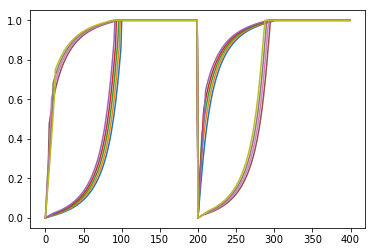

In [153]:
all_signals = np.zeros((len(z_values), Nt * 2))
for i in range(0, len(all_signals_1)):
    signal = np.concatenate((all_signals_1[i], all_signals_2[i]))
    all_signals[i] = signal

#for i in all_signals:
plt.plot(all_signals[0])
plt.plot(all_signals[1])
plt.plot(all_signals[2])
plt.plot(all_signals[3])
plt.plot(all_signals[4])
plt.plot(all_signals[-1])
plt.plot(all_signals[-2])
plt.plot(all_signals[-3])
plt.plot(all_signals[-4])
plt.show()

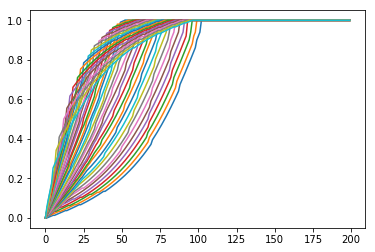

/home/anp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


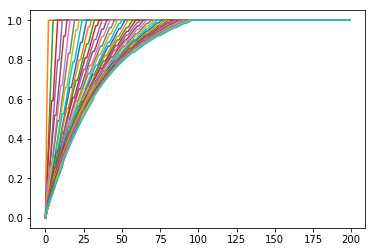

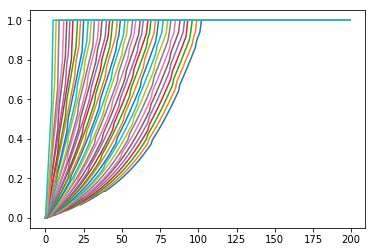

In [45]:
for i in all_signals:
    plt.plot(i)
plt.show()

for i in all_signals_e:
    i = i / np.amax(i)
    plt.plot(i)
plt.show()

for i in all_signals_h:
    i = i / np.amax(i)
    plt.plot(i)
plt.show()

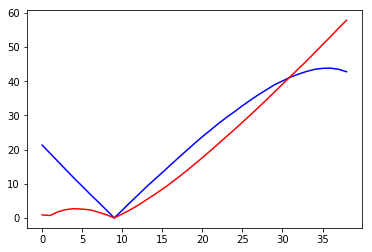

In [166]:
chi2_e = []
for i in range(1, len(all_signals),1):
    #print(max1, max0)
    sig1 = all_signals_1[i]
    sig0 = all_signals_1[10]
    chix = abs(np.sum(sig0-sig1)) 
    chi2_e.append(chix)
plt.plot(chi2_e, 'b')

chi2_h = []
for i in range(1, len(all_signals),1):
    sig1 = all_signals_2[i]
    sig0 = all_signals_2[10]
    chix = abs(np.sum(sig0-sig1))
    chi2_h.append(chix)
plt.plot(chi2_h, 'r')
plt.savefig('chi2_0.pdf')
plt.show()

In [ ]:
chi2_e = []
for i in range(1, len(all_signals),1):
    #print(max1, max0)
    sig1 = all_signals_1[i]
    sig0 = all_signals_1[18]
    chix = abs(np.sum(sig0-sig1)) 
    chi2_e.append(chix)
plt.plot(chi2_e, 'b')

chi2_h = []
for i in range(1, len(all_signals),1):
    sig1 = all_signals_2[i]
    sig0 = all_signals_2[18]
    chix = abs(np.sum(sig0-sig1))
    chi2_h.append(chix)
plt.plot(chi2_h, 'r')

plt.show()

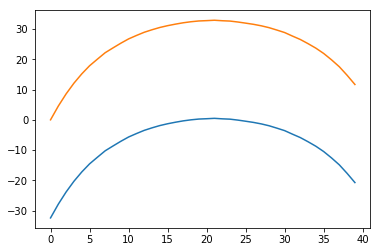

In [154]:
chi2 = []
for i in range(0, 40,1):
    chix = np.sum(all_signals[i] - all_signals[18])
    chi2.append(chix)
    #print(chix)
plt.plot(chi2)
#plt.show()

chi2 = []
for i in range(0, 40,1):
    chix = np.sum(all_signals[i] - all_signals[0])
    chi2.append(chix)
    #print(chix)
plt.plot(chi2)
plt.show()

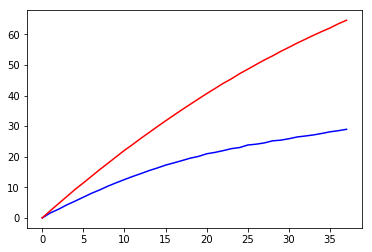

In [47]:
chi2_e = []
for i in range(1, 39,1):
    max1 =  np.amax(all_signals_e[i])
    max0 =  np.amax(all_signals_e[1])
    #print(max1, max0)
    sig1 = all_signals_e[i] / max1
    sig0 = all_signals_e[1] / max0
    chix = abs(np.sum(sig0-sig1)) 
    chi2_e.append(chix)
plt.plot(chi2_e, 'b')

chi2_h = []
for i in range(1, 39,1):
    sig1 = all_signals_h[i] / np.amax(all_signals_h[i])
    sig0 = all_signals_h[1] / np.amax(all_signals_h[1])
    chix = abs(np.sum(sig0-sig1))
    chi2_h.append(chix)
plt.plot(chi2_h, 'r')

plt.show()

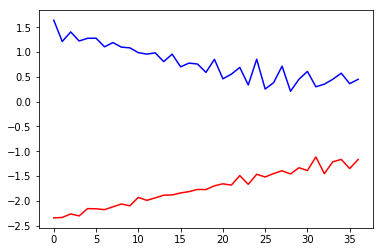

In [126]:
chi2_e = []
for i in range(2, 39,1):
    max1 =  np.amax(all_signals_e[i])
    max0 =  np.amax(all_signals_e[i-1])
    #print(max1, max0)
    sig1 = all_signals_e[i] / max1
    sig0 = all_signals_e[i-1] / max0
    chix = (np.sum(sig0-sig1)) 
    chi2_e.append(chix)
plt.plot(chi2_e, 'b')

chi2_h = []
for i in range(2, 39,1):
    sig1 = all_signals_h[i] / np.amax(all_signals_h[i])
    sig0 = all_signals_h[i-1] / np.amax(all_signals_h[i-1])
    chix = (np.sum(sig0-sig1))
    chi2_h.append(chix)
plt.plot(chi2_h, 'r')

plt.show()

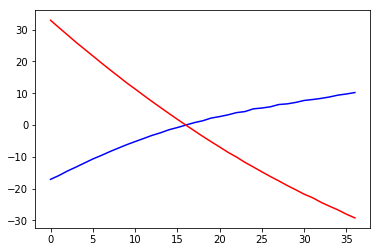

In [127]:
chi2_e = []
for i in range(2, 39,1):
    max1 =  np.amax(all_signals_e[i])
    max0 =  np.amax(all_signals_e[18])
    #print(max1, max0)
    sig1 = all_signals_e[i] / max1
    sig0 = all_signals_e[18] / max0
    chix = (np.sum(sig0-sig1)) 
    chi2_e.append(chix)
plt.plot(chi2_e, 'b')

chi2_h = []
for i in range(2, 39,1):
    sig1 = all_signals_h[i] / np.amax(all_signals_h[i])
    sig0 = all_signals_h[18] / np.amax(all_signals_h[18])
    chix = (np.sum(sig0-sig1))
    chi2_h.append(chix)
plt.plot(chi2_h, 'r')

plt.show()

In [ ]:
ristime_diffs = []

for i in range(0, 17):
    t50_e = 0
    t50_h = 0
    
    Qsignal = Qsignal_arr[i]
    
    high = 0
    low = 0
    
    #plt.plot(Qsignal_h)
    #plt.plot(Qsignal_e)
    #plt.show()
    
    
    for j in range(0, len(Qsignal)):
        #print(j)
        #print(Qsignal_e[j])
        #print(0.5*np.amax(Qsignal_e))
        if Qsignal[j] < 0.5*np.amax(Qsignal):
            low = j
        if Qsignal[j] > 0.5*np.amax(Qsignal):
            high = j
            break

    t50_1 = (high + low) / 2.0  # ns
    
    ristime_diffs.append(t50_1 )#- t50_2)
    

In [ ]:
plt.plot(ristime_diffs,'-')
plt.show()

In [ ]:
# set some detector parameters
strip_width_mm = 2.8
strip_gap_mm = 0.2
detector_thickness_mm = 16.0 #16.0
pixel_size_mm = 0.1

# set detector width to n*pitch where n is an odd number
detector_width_mm = (3*strip_width_mm+strip_gap_mm)


# In[204]:


# build some grids
x_range = np.arange(-detector_width_mm/2 + pixel_size_mm, detector_width_mm/2 + pixel_size_mm, pixel_size_mm)
y_range = np.arange(-pixel_size_mm, detector_thickness_mm + pixel_size_mm, pixel_size_mm)

# initialize grid for solving for V
N_xelements = np.shape(x_range)[0]
N_yelements = np.shape(y_range)[0]
V = np.zeros((N_xelements, N_yelements), dtype=float)
W = np.zeros((N_xelements, N_yelements), dtype=float)
E = np.zeros((N_xelements, N_yelements), dtype=float)


# In[205]:


# build a little map of geometry for later, designating pixels based on their nature
# Ge = 0 strip = 1 rest of strip surface = 2, back contact = 3, gap = 4
geom_map = np.zeros((N_xelements, N_yelements), dtype=int)

# continous contact
geom_map[:,0] = 3

ix = np.where((x_range>=(-strip_width_mm/2 - strip_gap_mm - strip_width_mm)) & (x_range<=(- strip_width_mm/2 - strip_gap_mm)))
geom_map[ix,0] = 3

ix = np.where((x_range>=(strip_width_mm/2 + strip_gap_mm)) & (x_range<=(strip_width_mm/2 + strip_gap_mm + strip_width_mm)))
geom_map[ix,0] = 3

# strip surface
geom_map[:,-1] = 2

ix = np.where((x_range>=(-strip_width_mm/2 - strip_gap_mm - strip_width_mm)) & (x_range<=(- strip_width_mm/2 - strip_gap_mm)))
geom_map[ix,-1] = 2

ix = np.where((x_range>=(strip_width_mm/2 + strip_gap_mm)) & (x_range<=(strip_width_mm/2 + strip_gap_mm + strip_width_mm)))
geom_map[ix,-1] = 2

# strip
ix = np.where((x_range>=-strip_width_mm/2) & (x_range<=strip_width_mm/2))
geom_map[ix,0] = 1

# gap
ix = np.where((x_range>strip_width_mm/2) & (x_range<=(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,-1] = 4
ix = np.where((x_range<-strip_width_mm/2) & (x_range>=-(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,-1] = 4

ix = np.where((x_range>strip_width_mm/2) & (x_range<=(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,0] = 4
ix = np.where((x_range<-strip_width_mm/2) & (x_range>=-(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,0] = 4


# In[206]:


# set boundary conditions

# non-strip contacts
[ix,iy] = np.where(geom_map == 2)
W[ix,iy] = 0
V[ix,iy] = 0

# back face
[ix,iy] = np.where(geom_map == 3)
W[ix,iy] = 0
V[ix,iy] = 1000

# strip
[ix,iy] = np.where(geom_map == 1)
W[ix,iy] = 1
V[ix,iy] = 0


# In[207]:


# do the relaxation
# set maximum number of iterations
max_iters = 1000

# "over-relaxation" factor to speed up convergence
t = np.cos(3.14/N_xelements) + np.cos(3.14/N_yelements)
w = (8 - np.sqrt(64 - 16*t*t)) / (t*t)

# initialise arrays which will store the residuals
R = np.zeros((N_xelements, N_yelements), dtype=float)
resid_store = np.zeros(max_iters)

# perform relaxation...
resid = 1e6
iterr = 1
min_resid = 0.01

while (iterr < max_iters and resid > min_resid):

    # loop over detector grid points
    for y in range(1, N_yelements-1):
        for x in range(0, N_xelements-1):

            # skip pixels with boundary conditions
            if ((geom_map[x,y] == 1) or (geom_map[x,y] == 2) or (geom_map[x,y] == 3)):
                continue

            # should deal with some boundary conditions...

            V_local_sum = (V[x+1,y] + V[x,y+1] + V[x-1,y] + V[x,y-1])

            # update the solution
            R[x,y] = 0.25*V_local_sum - V[x,y]
            V[x,y] = V[x,y] + w*R[x,y]

    # calculate the residual and store as a function of iteration number
    resid = abs(np.sum(R))
    resid_store[iterr] = resid

    # update iteration counter
    iterr+=1


# In[208]:


# visualise the weighting potential
# plot difference vs. iteration number
resid_store = resid_store[1:iterr]
plt.plot(np.arange(1,iterr), resid_store)
plt.grid("on")
plt.xlabel("Iteration Number")
plt.ylabel("Difference")
plt.yscale("log")
plt.savefig('finaldiff1.pdf')
plt.cla()
plt.clf()
#plt.show()

# also print the final difference
print("Final Difference:")
print(resid_store[-1])


# In[ ]:





# In[210]:


# do the relaxation
# set maximum number of iterations
max_iters = 1000

# "over-relaxation" factor to speed up convergence
t = np.cos(3.14/N_xelements) + np.cos(3.14/N_yelements)
w = (8 - np.sqrt(64 - 16*t*t)) / (t*t)

# initialise arrays which will store the residuals
R = np.zeros((N_xelements, N_yelements), dtype=float)
resid_store = np.zeros(max_iters)

# perform relaxation...
resid = 1e6
iterr = 1
min_resid = 0.01

while (iterr < max_iters and resid > min_resid):

    # loop over detector grid points
    for y in range(1, N_yelements-1):
        for x in range(0, N_xelements-1):

            # skip pixels with boundary conditions
            if ((geom_map[x,y] == 1) or (geom_map[x,y] == 2) or (geom_map[x,y] == 3)):
                continue

            # should deal with some boundary conditions...

            W_local_sum = (W[x+1,y] + W[x,y+1] + W[x-1,y] + W[x,y-1])

            # update the solution
            R[x,y] = 0.25*W_local_sum - W[x,y]
            W[x,y] = W[x,y] + w*R[x,y]

    # calculate the residual and store as a function of iteration number
    resid = abs(np.sum(R))
    resid_store[iterr] = resid

    # update iteration counter
    iterr+=1


# In[211]:


# visualise the weighting potential
# plot difference vs. iteration number
resid_store = resid_store[1:iterr]
plt.plot(np.arange(1,iterr), resid_store)
plt.grid("on")
plt.xlabel("Iteration Number")
plt.ylabel("Difference")
plt.yscale("log")
plt.savefig('diff2.pdf')
plt.cla()
plt.clf()
#plt.show()

# also print the final difference
print("Final Difference:")
print(resid_store[-1])


# In[212]:


X, Y = np.meshgrid(y_range, x_range)
plt.contourf(Y,X, V, 30)
plt.xlim(-detector_width_mm/2, detector_width_mm/2)
plt.colorbar()


# In[213]:


X, Y = np.meshgrid(y_range, x_range)
plt.contourf(Y,X, W, 30)
plt.xlim(-detector_width_mm/2, detector_width_mm/2)
plt.colorbar()


# In[254]:


# take a slice through the V
x_slice = 125
Vslice = V[x_slice,:]

plt.plot(y_range, Vslice, 'b-',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("V")
plt.xlim(0, 16.1)
plt.ylim(0, 1000)
plt.show()

# take a slice through the V
x_slice = 125
Vslice = V[x_slice,:]
Vfunc = interp1d(y_range, Vslice, kind='cubic')

plt.plot(y_range, Vslice, 'b-',linewidth=2)
plt.plot(y_range, Vfunc(y_range), 'ro',linewidth=1)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("V")
plt.xlim(0, 1.1)
plt.ylim(0, 1000)

plt.show()


# In[297]:


#print(len(Eslice))
#print(len(Vslice))
#print(len(y))
# take a slice through the WP

x_slice = N_xelements/2
Eslice = -1 * np.gradient(Vslice) #V[x_slice,:]
#Eslice = np.insert(Eslice, 0, Eslice[0])
y = np.linspace(0, N_yelements,N_yelements)

Efunc = interp1d(y, Eslice, kind='cubic')
plt.plot(y, Efunc(y), 'ro',linewidth=1)

#print(y)
plt.plot(y, Eslice, 'b--',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("V")
#plt.xlim(0, 16.1)
#plt.ylim(0, 1000)
plt.show()


# In[298]:


# take a slice through the WP

x_slice = N_xelements/2
Wslice = W[x_slice,:]

y = np.linspace(0, N_yelements,N_yelements)

Wfunc = interp1d(y, Wslice, kind='cubic')
plt.plot(y, Wfunc(y), 'ro',linewidth=1)

#print(y)
plt.plot(y, Wslice, 'b--',linewidth=2)

#plt.plot(y, Wslice, 'bo',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("W")
#plt.xlim(0, 1)
#plt.ylim(0, 0.1)
plt.show()


# In[322]:


eps_0 = 8.85 * 10 ** (-14)
eps = 16 * eps_0
rho = 10**10  # cm^-3
q = 1.6 * 10 ** (-19)
#Voltage = 1000 # V

# assume an interaction position at a given depth
depth_mm = 0.2

z0 = np.int(np.floor(depth_mm / pixel_size_mm))
print('z0: ',z0)
maxval = 1.0 / pixel_size_mm

# number of time steps in signal
Nt = 200

# arrays which will store the induced charge signals
Qh = np.zeros(Nt, dtype=float)
Qe = np.zeros(Nt, dtype=float)

# starting positions for electrons and holes
zh_list = []
ze_list = []
zh_list.append(z0)
ze_list.append(z0)
# holes into wp
t = 0
x_list = []
zh = z0
ze = z0
w_e_vals = []
w_h_vals = []
for t in range(1, Nt):
    x = zh_list[-1]
    eslice = Efunc(x)
    muh = float(hfunc(eslice))
    vh = muh * eslice
    zh = np.int(zh + np.floor(vh / pixel_size_mm))

    #print(x, Eslice[x])
    #print(mue, muh)
    #print(vh)
    #print('zh', zh)

    if zh <= 0:
        zh = 0
    if zh >= int(maxval):
        zh = int(maxval)
    zh_list.append(zh)
    #x_list.append(x_list[-1] + np.floor(vh))
    if (zh== maxval) and (x== maxval):
        dw = Wfunc(zh_list[t]) - Wfunc(zh_list[t-1])
        w_h_vals.append(1.0)
        Qh[t] = round(1.0*dw,4)
    elif (zh<=N_yelements-1):
        dw = Wfunc(zh_list[t]) - Wfunc(zh_list[t-1])
        w_h_vals.append(Wfunc(zh_list[t]))
        w_h_vals.append(Wfunc(zh_list[t-1]))
        Qh[t] = round(1.0*dw,4)

# electrons out of wp
t = 0
for t in range(1, Nt):
    x = ze_list[-1]
    eslice = Efunc(x)
    mue = float(efunc(eslice))
    ve = mue * eslice
    ze = np.int(ze - np.floor(ve / pixel_size_mm))

    if ze <= 0:
        ze = 0
    if ze >= int(maxval):
        ze = int(maxval)
    ze_list.append(ze)
    #x_list.append(x_list[-1] + np.floor(vh))
    if (ze== 0)and( x!= 0):
        #print('min')
        #print(ze_list[t])
        #print(ze_list[t-1])
        dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
        w_e_vals.append(1.0)
        Qe[t] = round(1.0*dw,4)
        #print(dw)
        #print(np.cumsum(Qe)[-1])
       # continue
    elif (ze== 0)and( x== 0):
        dw = 0.0
        w_e_vals.append(1.0)
        Qe[t] = -1 * round(1.0*dw,2)

    elif (ze<=N_yelements-1):
        dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
        w_e_vals.append(Wfunc(ze_list[t]))
        w_e_vals.append(Wfunc(ze_list[t-1]))
        Qe[t] = round(1.0*dw,4)

Qh = Qh
Qe = - Qe
# take cumulative sums
Qsignal_h = np.cumsum(Qh)
Qsignal_e = np.cumsum(Qe)
Qsignal = np.cumsum(Qe + Qh)

plt.plot(zh_list,'r-')
plt.plot(ze_list,'b-')
plt.show()

# plot
plt.plot(Qsignal_e, 'c', linewidth=1.5)
plt.plot(Qsignal_h, 'm', linewidth=1.5)
plt.plot(Qsignal, 'k', linewidth=2)

plt.grid("on")
#plt.ylim(0,1)
plt.xlim(0, Nt)
#plt.tick_params(labelbottom="off")
plt.xlabel("Time")
plt.ylabel("Charge (au)")
#plt.legend()
plt.show()


# In[333]:


Qsignal_h_arr = np.zeros((17,200), dtype=float)
Qsignal_e_arr = np.zeros((17,200), dtype=float)
Qsignal_arr = np.zeros((17,200), dtype=float)

# assume an interaction position at a given depth
for i in range(0,10,1):
    depth_mm = float(i / 10.0)

    # assume an interaction position at a given depth

    z0 = np.int(np.floor(depth_mm / pixel_size_mm))
    print('z0: ',z0)
    maxval = 1.0 / pixel_size_mm

    # number of time steps in signal
    Nt = 200

    # arrays which will store the induced charge signals
    Qh = np.zeros(Nt, dtype=float)
    Qe = np.zeros(Nt, dtype=float)

    # starting positions for electrons and holes
    zh_list = []
    ze_list = []
    zh_list.append(z0)
    ze_list.append(z0)
    # holes into wp
    t = 0
    x_list = []
    zh = z0
    ze = z0
    w_e_vals = []
    w_h_vals = []
    for t in range(1, Nt):
        x = zh_list[-1]
        eslice = Efunc(x)
        muh = float(hfunc(eslice))
        vh = muh * eslice
        zh = np.int(zh + np.floor(vh / pixel_size_mm))

        #print(x, Eslice[x])
        #print(mue, muh)
        #print(vh)
        #print('zh', zh)

        if zh <= 0:
            zh = 0
        if zh >= int(maxval):
            zh = int(maxval)
        zh_list.append(zh)
        #x_list.append(x_list[-1] + np.floor(vh))
        if (zh== maxval) and (x== maxval):
            #print('max')
            #print(zh_list[t])
            #print(zh_list[t-1])
            dw = Wfunc(zh_list[t]) - Wfunc(zh_list[t-1])
            w_e_vals.append(1.0)
            Qh[t] = round(1.0*dw,2)
            #print(dw)
            #print(np.cumsum(Qh)[-1])
           # continue
        elif (zh<=N_yelements-1):
            dw = Wfunc(zh_list[t]) - Wfunc(zh_list[t-1])
            w_e_vals.append(Wfunc(zh_list[t]))
            w_e_vals.append(Wfunc(zh_list[t-1]))
            Qh[t] = round(1.0*dw,2)
            #print('nm')
            #print(dw)
            #print(np.cumsum(Qh)[-1])


    # electrons out of wp
    t = 0
    for t in range(1, Nt):
        x = ze_list[-1]
        eslice = Efunc(x)
        mue = float(efunc(eslice))
        ve = mue * eslice
        ze = np.int(ze - np.floor(ve / pixel_size_mm))


        if ze <= 0:
            ze = 0
        if ze >= int(maxval):
            ze = int(maxval)
        ze_list.append(ze)
        #x_list.append(x_list[-1] + np.floor(vh))
        if (ze== 0)and( x!= 0):
            dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
            w_e_vals.append(1.0)
            Qe[t] = -1 * round(1.0*dw,2)
            #print('min')
            #print(ze_list[t])
            #print(ze_list[t-1])
            #print(dw)
            #print(np.cumsum(Qe)[-1])
           # continue
        elif (ze== 0)and( x== 0):
            dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
            w_e_vals.append(1.0)
            Qe[t] = -1 * round(1.0*dw,2)
            #print('miny')
            #print(ze_list[t])
            #print(ze_list[t-1])
            #print(dw)
            #print(np.cumsum(Qe)[-1])
           # continue
        elif (zh<=N_yelements-1):
            dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
            w_e_vals.append(Wfunc(ze_list[t]))
            w_e_vals.append(Wfunc(ze_list[t-1]))
            Qe[t] = -1 * round(1.0*dw,2)
            #print('nm')
            #print(dw)
            #print(np.cumsum(Qe)[-1])
            ###

    #Qh = Qh
    #Qe = -1 * Qe
    # take cumulative sums
    Qsignal_h = np.cumsum(Qh)
    Qsignal_e = np.cumsum(Qe)
    Qsignal = np.cumsum(Qe + Qh)

    Qsignal_h_arr[i] = Qsignal_h
    Qsignal_e_arr[i] = Qsignal_e
    Qsignal_arr[i] = Qsignal

    plt.plot(zh_list,'r-')
    plt.plot(ze_list,'b-')
    plt.show()

    # plot
    plt.plot(Qsignal_e, 'c-', linewidth=1.5)
    plt.plot(Qsignal_h, 'm-', linewidth=1.5)
    plt.plot(Qsignal, 'k-', linewidth=2)

    plt.grid("on")
    #plt.ylim(0,1)
    plt.xlim(0, Nt)
    #plt.tick_params(labelbottom="off")
    plt.xlabel("Time")
    plt.ylabel("Charge (au)")
    #plt.legend()
    plt.show()

